- same trade for same rtrs_control_number
- dollar price is on occassion null, exclude those! 
- yield can be null for trades in the same cusip in the same sequence of trades 
- exclude negative yields 
- interest_payment_frequency, coupon_type


- are called trades included?

In [1]:
%load_ext autoreload
%autoreload 2

from ficc_debiasing import *
import functions_framework
from auxiliary_functions import *
import datetime
import pytz
import os
import regex as re
from modules.ficc.utils.diff_in_days import *
import matplotlib.pyplot as plt
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
redis_client = redis.Redis(host='10.14.140.37', port=6379, db=0)

YYYYMMDD = "%Y-%m-%d"
last_updated = None
tz = pytz.timezone('US/Eastern')
cusip_ref_set = set()
cusip_ref_df = pd.DataFrame()
relevant_cols = ['cusip', 'next_call_date', 'maturity_date', 'refund_date', 'interest_payment_frequency', 'coupon_type', 'default_indicator', 'moodys_Issue_Long_Rating', 'sp_long', 'incorporated_state_code']

weighting_col = 'error'
error_col = 'error'
groupby_cols = ['trade_date']
window_size = 750
weighting_method = 'simple_average'
mask_large = 35
N_warm = 500
now = datetime.datetime.now(tz)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# with fs.open(f'gs://biases/bias_{date}.pkl', 'rb') as f:
#     biases = pickle.load(f)
with fs.open(f'gs://biases/trade_log_{now.strftime(YYYYMMDD)}.pkl', 'rb') as f:
    trades_df = pickle.load(f)
    
for col in ['yield', 'prediction', 'error']:
    trades_df[col] = trades_df[col]*100
    
trades_df = trades_df[trades_df.trade_date>=now.strftime(YYYYMMDD)]
# biases = np.array(biases)*100

In [414]:
absent_cusips = []
for cusip in trades_df.cusip.unique():
    if cusip not in cusip_ref_set:
        absent_cusips.append(cusip)

In [224]:
cusip_ref = redis_client.mget(absent_cusips)
missing_cusips = []
x = dict(zip(absent_cusips, cusip_ref))
with open('missing_cusips.txt', 'w') as f:
    for key, value in x.items():
        if not value: 
            f.write(key)
            f.write('\n')

In [418]:
def get_cusip_ref(cusip_list, redis_client):
    global cusip_ref_df, cusip_ref_set
    
    if not len(cusip_list):
        return
    
    cusip_ref = redis_client.mget(cusip_list)
    cusip_ref = [pickle.loads(x) for x in cusip_ref if x]
    
    if not len(cusip_ref_df):
        cusip_ref_df = pd.DataFrame(cusip_ref)[relevant_cols]
        
    else: 
        temp = pd.DataFrame(cusip_ref)[relevant_cols]
        cusip_ref_df = pd.concat([cusip_ref_df, temp])
        
    cusip_ref_set.update(cusip_list)

def get_days(row, col):
    if pd.isna(row[col]):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.trade_datetime+pd.Timedelta(days=2))
        if diff <= 0:
            return -1
        else:
            return diff
        
def summarize_trades_df(trades_df):
    print(f'{"Number of trades": <20}: {len(trades_df)}')
    print(f'{"trade_datetime": <20}: min: {trades_df.trade_datetime.min()}, max: {trades_df.trade_datetime.max()}')
    print(f'{"published_datetime": <20}: min: {trades_df.published_datetime.min()}, max: {trades_df.published_datetime.max()}')
    print(f'{"error distribution": <20}: mean: {trades_df.error.mean()}, std: {trades_df.error.std()}, min: {trades_df.error.min()}, max: {trades_df.error.max()}, median: {trades_df.error.median()}')
    print(f'{"error quantiles": <20}: 1%: {trades_df.error.quantile(.01)}, 25%: {trades_df.error.quantile(.25)}, 75%: {trades_df.error.quantile(.75)}, 99%: {trades_df.error.quantile(.99)}')
    print(f'{"Yield": <20}: 1%: mean: {trades_df["yield"].mean()}, std: {trades_df["yield"].std()}, min: {trades_df["yield"].min()}, max: {trades_df["yield"].max()}, median: {trades_df["yield"].median()}')
    
def get_one_cusip_ref(cusip):
    return pickle.loads(redis_client.get(cusip)).to_frame().T

In [226]:
summarize_trades_df(trades_df)

Number of trades    : 38822
trade_datetime      : min: 2023-06-30 06:00:01, max: 2023-06-30 17:55:49
published_datetime  : min: 2023-06-30 07:30:06, max: 2023-06-30 17:56:10
error distribution  : mean: -1.5555659709438836, std: 102.41520783976964, min: -7054.931573988508, max: 4733.515831860082, median: -0.27026933882501325
error quantiles     : 1%: -108.92903740562164, 25%: -8.121918573471753, 75%: 6.448955736307882, 99%: 74.43142900153475
Yield               : 1%: mean: 367.16973623203336, std: 133.49238477068548, min: -4309.2, max: 7774.8, median: 352.2


In [422]:
start = time.time()

absent_cusips = []
for cusip in trades_df.cusip.unique():
    if cusip not in cusip_ref_set:
        absent_cusips.append(cusip)
        
print(f'Retrieving reference data for {len(absent_cusips)} cusips. Data for these cusips not previously loaded in memory.')
redis_start = time.time()
get_cusip_ref(absent_cusips, redis_client)
print(f'Data retrieval took {time.time() - redis_start:.2f} seconds.')

print('Calculating days to maturity, next call and refund and filtering trades.')
trades_df = pd.merge(trades_df.reset_index(), cusip_ref_df, left_on='cusip', right_on='cusip')
trades_df['days_to_call'] = trades_df[['trade_datetime','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)
trades_df['days_to_maturity'] = trades_df[['trade_datetime','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)
trades_df['days_to_refund'] = trades_df[['trade_datetime','refund_date']].apply(lambda x: get_days(x, 'refund_date'), axis = 1)

data = trades_df.copy()
N = len(data)
data = data[(data.days_to_call == 0) | (data.days_to_call > 400)]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > 400)]
data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > 400)]
data = data[data.days_to_maturity < 30000]
data = data[data.par_traded >= 10000]
data = data[data['yield'] >= 0]
data = data[trades_df.interest_payment_frequency.isin([1,2,3,5,16])]
data = data[trades_df.coupon_type.isin([8, 4, 10, 17])]
data['quantity'] = np.log10(data.par_traded)
print(f'Filtering removed {N-len(data)} trades, down from {N} to {len(data)}.')

Retrieving reference data for 18814 cusips. Data for these cusips not previously loaded in memory.
Data retrieval took 24.61 seconds.
Calculating days to maturity, next call and refund and filtering trades.
Filtering removed 11778 trades, down from 50191 to 38413.


In [433]:
temp = data[data.incorporated_state_code == 'TX']
temp['hour'] = temp['trade_datetime'].dt.hour
temp['minute'] = temp['trade_datetime'].dt.minute
temp.groupby(['hour','minute']).size().sort_values().tail(10)

hour  minute
12    29         33
14    15         38
10    24         40
11    21         45
      9          47
12    24         48
13    47         66
11    57         66
15    17         87
      15        183
dtype: int64

In [444]:
temp.groupby(['hour','minute']).cusip.unique().apply(lambda x: len(x)).sort_values()

hour  minute
5     36          1
11    13          1
10    42          1
      30          1
      17          1
               ... 
      24         34
13    47         47
15    17         47
11    57         51
15    15        111
Name: cusip, Length: 510, dtype: int64

In [470]:
texas_cusips = temp.groupby(['hour','minute']).cusip.unique().loc[15,15]

In [458]:
temp[(temp.hour == 15) & (temp.minute==15) & (temp.incorporated_state_code == 'TX')& (temp.trade_type == 'S')].sp_long.value_counts()

AAA    44
AA+    27
AA     10
AA-     5
Name: sp_long, dtype: int64

In [464]:
temp[(temp.hour == 15) & (temp.minute==15) & (temp.incorporated_state_code == 'TX')& (temp.trade_type == 'S')].sort_values(by='error')[['cusip','par_traded','prediction','yield','error']]

,cusip,par_traded,prediction,yield,error
44473,3434876A7,25000.0,320.418912,328.9,-8.481088
44782,2837342S9,45000.0,322.513728,330.0,-7.486272
20480,208399S30,15000.0,340.698718,348.1,-7.401282
44801,2487753Z9,30000.0,304.023141,311.0,-6.976859
44386,413000QP8,15000.0,323.852372,329.9,-6.047628
...,...,...,...,...,...
44689,448492N95,35000.0,306.637161,288.0,18.637161
44596,385050YW3,20000.0,306.952535,288.0,18.952535
44681,235219MU3,15000.0,325.284879,305.7,19.584879
44447,283822PK4,15000.0,316.570057,293.7,22.870057


In [227]:
start = time.time()

absent_cusips = []
for cusip in trades_df.cusip.unique():
    if cusip not in cusip_ref_set:
        absent_cusips.append(cusip)
        
print(f'Retrieving reference data for {len(absent_cusips)} cusips. Data for these cusips not previously loaded in memory.')
redis_start = time.time()
get_cusip_ref(absent_cusips, redis_client)
print(f'Data retrieval took {time.time() - redis_start:.2f} seconds.')

print('Calculating days to maturity, next call and refund and filtering trades.')
trades_df = pd.merge(trades_df.reset_index(), cusip_ref_df, left_on='cusip', right_on='cusip')
trades_df['days_to_call'] = trades_df[['trade_datetime','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)
trades_df['days_to_maturity'] = trades_df[['trade_datetime','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)
trades_df['days_to_refund'] = trades_df[['trade_datetime','refund_date']].apply(lambda x: get_days(x, 'refund_date'), axis = 1)

data = trades_df.copy()
N = len(data)
data = data[(data.days_to_call == 0) | (data.days_to_call > 400)]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > 400)]
data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > 400)]
data = data[data.days_to_maturity < 30000]
data = data[data.par_traded >= 10000]
data = data[data['yield'] >= 0]
data = data[trades_df.interest_payment_frequency.isin([1,2,3,5,16])]
data = data[trades_df.coupon_type.isin([8, 4, 10, 17])]
data['quantity'] = np.log10(data.par_traded)
print(f'Filtering removed {N-len(data)} trades, down from {N} to {len(data)}.')

Retrieving reference data for 1125 cusips. Data for these cusips not previously loaded in memory.
Data retrieval took 1.47 seconds.
Calculating days to maturity, next call and refund and filtering trades.
Filtering removed 9230 trades, down from 38821 to 29591.


In [228]:
data[data.error.apply(np.abs) <= 35].sort_values(by='yield', ascending=False).head(50)

,index,trade_date,trade_datetime,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,...,refund_date,interest_payment_frequency,coupon_type,default_indicator,moodys_Issue_Long_Rating,sp_long,days_to_call,days_to_maturity,days_to_refund,quantity
2469,2023063000600400,2023-06-30,2023-06-30 09:09:13,2023-06-30 09:11:21,P,I,10604PAF0,1500000.0,1199.5,1223.222167,...,NaT,1,8,False,None,None,1049,7169,0,6.176091
18460,2023063003632700,2023-06-30,2023-06-30 11:35:08,2023-06-30 11:37:12,S,I,64542PBH7,60000.0,1188.9,1183.104832,...,NaT,1,17,True,None,NR,1079,2879,0,4.778151
30975,2023063007055800,2023-06-30,2023-06-30 13:56:18,2023-06-30 13:57:32,D,I,08451PAL5,20000.0,1150.0,1157.757262,...,NaT,1,8,False,WR,B,1559,2999,0,4.301030
30799,2023063006756800,2023-06-30,2023-06-30 13:34:00,2023-06-30 13:38:47,S,I,687241AL3,55000.0,1100.6,1102.722238,...,NaT,1,8,True,None,B+,2069,9269,0,4.740363
27989,2023063005997500,2023-06-30,2023-06-30 13:00:05,2023-06-30 13:00:37,D,I,36829QAA3,11000.0,1006.8,996.949219,...,NaT,1,17,False,None,None,0,6168,0,4.041393
13995,2023063002746200,2023-06-30,2023-06-30 11:07:07,2023-06-30 11:07:54,S,I,74446GAC5,15000.0,876.9,862.090229,...,NaT,1,8,False,None,None,1379,11099,0,4.176091
13996,2023063002776200,2023-06-30,2023-06-30 11:08:08,2023-06-30 11:08:51,S,I,74446GAC5,10000.0,876.9,862.881000,...,NaT,1,8,False,None,None,1379,11099,0,4.000000
23657,2023063005414400,2023-06-30,2023-06-30 12:37:30,2023-06-30 12:51:48,D,I,13080SLL6,250000.0,875.2,881.119991,...,NaT,1,8,True,None,NR,749,7769,0,5.397940
23656,2023063005543500,2023-06-30,2023-06-30 12:34:00,2023-06-30 13:33:51,S,C,13080SLL6,250000.0,873.4,875.335597,...,NaT,1,8,True,None,NR,749,7769,0,5.397940
23658,2023063005379400,2023-06-30,2023-06-30 12:36:01,2023-06-30 13:27:43,D,I,13080SLL6,250000.0,873.4,884.948238,...,NaT,1,8,True,None,NR,749,7769,0,5.397940


In [ ]:
data[data.sp_long == 'B']

,index,trade_date,trade_datetime,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,...,refund_date,interest_payment_frequency,coupon_type,default_indicator,moodys_Issue_Long_Rating,sp_long,days_to_call,days_to_maturity,days_to_refund,quantity
29743,2023063006792800,2023-06-30,2023-06-30 13:41:30,2023-06-30 13:41:39,D,I,08451PAL5,20000.0,1150.0,902.058797,...,NaT,1,8,False,WR,B,1559,2999,0,4.30103
29744,2023063006792700,2023-06-30,2023-06-30 13:41:29,2023-06-30 13:41:39,P,I,08451PAL5,20000.0,1163.0,930.413351,...,NaT,1,8,False,WR,B,1559,2999,0,4.30103
29745,2023063006793500,2023-06-30,2023-06-30 13:41:28,2023-06-30 13:42:12,D,I,08451PAL5,20000.0,1150.0,902.059103,...,NaT,1,8,False,WR,B,1559,2999,0,4.30103
29746,2023063007055800,2023-06-30,2023-06-30 13:56:18,2023-06-30 13:57:32,D,I,08451PAL5,20000.0,1150.0,1157.757262,...,NaT,1,8,False,WR,B,1559,2999,0,4.30103


In [ ]:
data.groupby('sp_long').error.mean().sort_values()

sp_long
B      -180.177872
B-      -10.958785
BBB      -3.023832
BB       -1.925075
BBB-     -1.158225
A-       -1.141953
A+       -0.554193
A        -0.426586
AA+      -0.128955
AA        0.243937
AAA       0.608709
BBB+      1.506075
AA-       1.609909
B+        2.122238
NR        5.629046
BB+      17.309862
Name: error, dtype: float64

In [67]:
summarize_trades_df(data)

Number of trades    : 23470
trade_datetime      : min: 2023-06-30 06:00:01, max: 2023-06-30 14:31:46
published_datetime  : min: 2023-06-30 07:30:06, max: 2023-06-30 14:31:58
error distribution  : mean: -0.017342169343156816, std: 16.86552782882701, min: -452.0382000657837, max: 227.6219753735715, median: 0.16192923005202697
error quantiles     : 1%: -47.57041852246089, 25%: -6.146527356124198, 75%: 6.204626167529847, 99%: 43.903898384282336
Yield               : 1%: mean: 361.9674392841926, std: 74.8768980657752, min: 177.29999999999998, max: 1628.9, median: 345.6


In [3]:
def run_debiasing(data, window = 1000, mask_large = 45):
    debias_series(data.prediction, data['yield'], bias_warm_start(simulate_weighted_average(data, 
                                                                                                 weighting_col = 'quantity', 
                                                                                                 error_col = 'error', 
                                                                                                 groupby_cols=['trade_date'], 
                                                                                                 window_size=window, 
                                                                                                 weighting_method='default', 
                                                                                                 mask_large=mask_large),
                                                                                          500))

    debias_series(data.prediction, data['yield'], bias_warm_start(simulate_weighted_average(data, 
                                                                                                     weighting_col = 'error', 
                                                                                                     error_col = 'error', 
                                                                                                     groupby_cols=['trade_date'], 
                                                                                                     window_size=window, 
                                                                                                     weighting_method='simple_average', 
                                                                                                     mask_large=mask_large),
                                                                                              500))

    debias_series(data.prediction, data['yield'], bias_warm_start(simulate_weighted_average(data, 
                                                                                                     weighting_col = 'error', 
                                                                                                     error_col = 'error', 
                                                                                                     groupby_cols=['trade_date'], 
                                                                                                     window_size=window, 
                                                                                                     weighting_method='log', 
                                                                                                     mask_large=mask_large),
                                                                                              500))

In [5]:
%%time

run_debiasing(biases[0], 1000, 35)
print('='*75)
run_debiasing(biases[0], 2000, 35)

NameError: name 'biases' is not defined

In [147]:
%%time

run_debiasing(data, 500, 45)
print('='*75)
run_debiasing(data, 500, 35)
print('='*75)
run_debiasing(data, 1000, 35)
print('='*75)
run_debiasing(data, 1000, 45)
print('='*75)
run_debiasing(data, 2000, 35)
print('='*75)
run_debiasing(data, 2000, 45)
print('='*75)

Ignoring trades with errors larger than 45bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.238, Corrected MAE: 10.127
Ignoring trades with errors larger than 45bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.201, Corrected MAE: 10.123
Ignoring trades with errors larger than 45bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.276, Corrected MAE: 10.246
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.143, Corrected MAE: 10.109
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.106, Corrected MAE: 10.107
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.095, Co

In [148]:
biases = bias_warm_start(simulate_weighted_average(data, 
                                                 weighting_col = 'error', 
                                                 error_col = 'error', 
                                                 groupby_cols=['trade_date'], 
                                                 window_size=2000, 
                                                 weighting_method='simple_average', 
                                                 mask_large=35),
                                          500)
data['bias'] = biases

Ignoring trades with errors larger than 35bps in bias correction calculations.


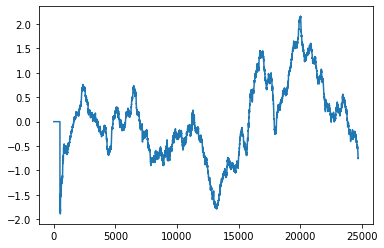

In [149]:
plt.plot(range(len(biases)), biases)

In [150]:
trades_df_final = pd.merge(trades_df.set_index('index'), 
         data.set_index('index')[['bias']], 
         left_index=True, 
         right_index=True,
                          how='outer')
trades_df_final['bias'] = trades_df_final['bias'].ffill()

In [151]:
debias_series(data.prediction, data['yield'], data.bias)

Original bias: -0.086, Original MAE: 10.090, Corrected bias: -0.103, Corrected MAE: 10.089


In [152]:
debias_series(trades_df_final.prediction, trades_df_final['yield'], trades_df_final.bias)

Original bias: -2.354, Original MAE: 17.146, Corrected bias: -2.376, Corrected MAE: 17.146


In [38]:
def analyze_debiasing_day(date, df, bias_correction, prediction_col = 'prediction', target_col='new_ys', first_N_trades = 500, last_N_trades = 200, print_graphs = True):
    '''Calculates debiased predictions for a given day and prints graphs for comparison of MAE.'''
    
    
    summary = df.copy()
    summary.loc[:, 'bias_correction'] = bias_correction
    summary.loc[:,'debiased_prediction'] = summary[prediction_col] - bias_correction
    summary.loc[:,'original_error'] = summary[target_col] - summary[prediction_col]
    summary.loc[:,'debiased_error'] = summary[target_col] - summary['debiased_prediction']
    # summary = summary.loc[date].sort_values(by='trade_datetime', ascending=True)
    
    
    if print_graphs:
        N = len(summary)
        
        if N < first_N_trades:
            first_N_trades = N
            print(f'Only {N} trades in data for {date}, defaulting {first_N_trades} to {N}')

        if N < last_N_trades:
            last_N_trades = N
            print(f'Only {N} trades in data for {date}, defaulting {last_N_trades} to {N}')


        win_rates_df = pd.DataFrame()
        win_rates_df['win_rate_original'] = np.cumsum(np.where(summary['debiased_error'].apply(abs) > summary['original_error'].apply(abs), 1, 0))
        win_rates_df['win_rate_debiased'] = np.cumsum(np.where(summary['debiased_error'].apply(abs) < summary['original_error'].apply(abs), 1, 0))


        rolling_MAE_original = summary.expanding(min_periods=1)['original_error'].apply(lambda x: np.average(np.abs(x)))
        rolling_MAE_debiased = summary.expanding(min_periods=1)['debiased_error'].apply(lambda x: np.average(np.abs(x)))
        
        print(f'OVERALL ORIGINAL MAE: {rolling_MAE_original.iloc[-1].mean():.2f}, OVERALL DEBIASED MAE: {rolling_MAE_debiased.iloc[-1].mean():.2f}')

        fig, ax = plt.subplots(4, 1, figsize=(20, 40))
        s = 8

        ax[0].scatter(range(last_N_trades), summary[prediction_col][-last_N_trades:], label='Original', s = s, c = 'blue')
        ax[0].scatter(range(last_N_trades), summary[target_col][-last_N_trades:], label='Truth', s = s, c='green')
        ax[0].scatter(range(last_N_trades), summary['debiased_prediction'][-last_N_trades:], label='Corrected', s = s, c = 'red')
        ax[0].set_title(f'Visualization of Actual, Original Predicted, Debiased Predicted {target_col} on {date} for last {last_N_trades} trades')
        ax[0].legend()

        ax[1].plot(range(N), win_rates_df['win_rate_original'], label='Original Prediction Wins')
        ax[1].plot(range(N), win_rates_df['win_rate_debiased'], label='Debiased Prediction Wins')       
        # ax[1].scatter(win_rates_df['win_rate_original'].dropna().index, win_rates_df['win_rate_original'].dropna(), label='ORIGINAL', c='red')
        # ax[1].scatter(win_rates_df['win_rate_debiased'].dropna().index, win_rates_df['win_rate_debiased'].dropna(), label='DEBIASED', c='blue')    
        ax[1].set_title(f'Model Wins for {date}')
        ax[1].legend()


        ax[2].plot(range(N), rolling_MAE_original, label='rolling_MAE_original')
        ax[2].plot(range(N), rolling_MAE_debiased, label='rolling_MAE_debiased')       
        ax[2].set_title(f'Rolling Average MAE for {date}')
        ax[2].legend()

        ax[3].plot(range(first_N_trades), rolling_MAE_original[:first_N_trades], label='rolling_MAE_original')
        ax[3].plot(range(first_N_trades), rolling_MAE_debiased[:first_N_trades], label='rolling_MAE_debiased')        
        ax[3].set_title(f'Rolling Average MAE for {date} for first {first_N_trades} trades') 
        ax[3].legend()
    
    return summary    

OVERALL ORIGINAL MAE: 17.15, OVERALL DEBIASED MAE: 17.15


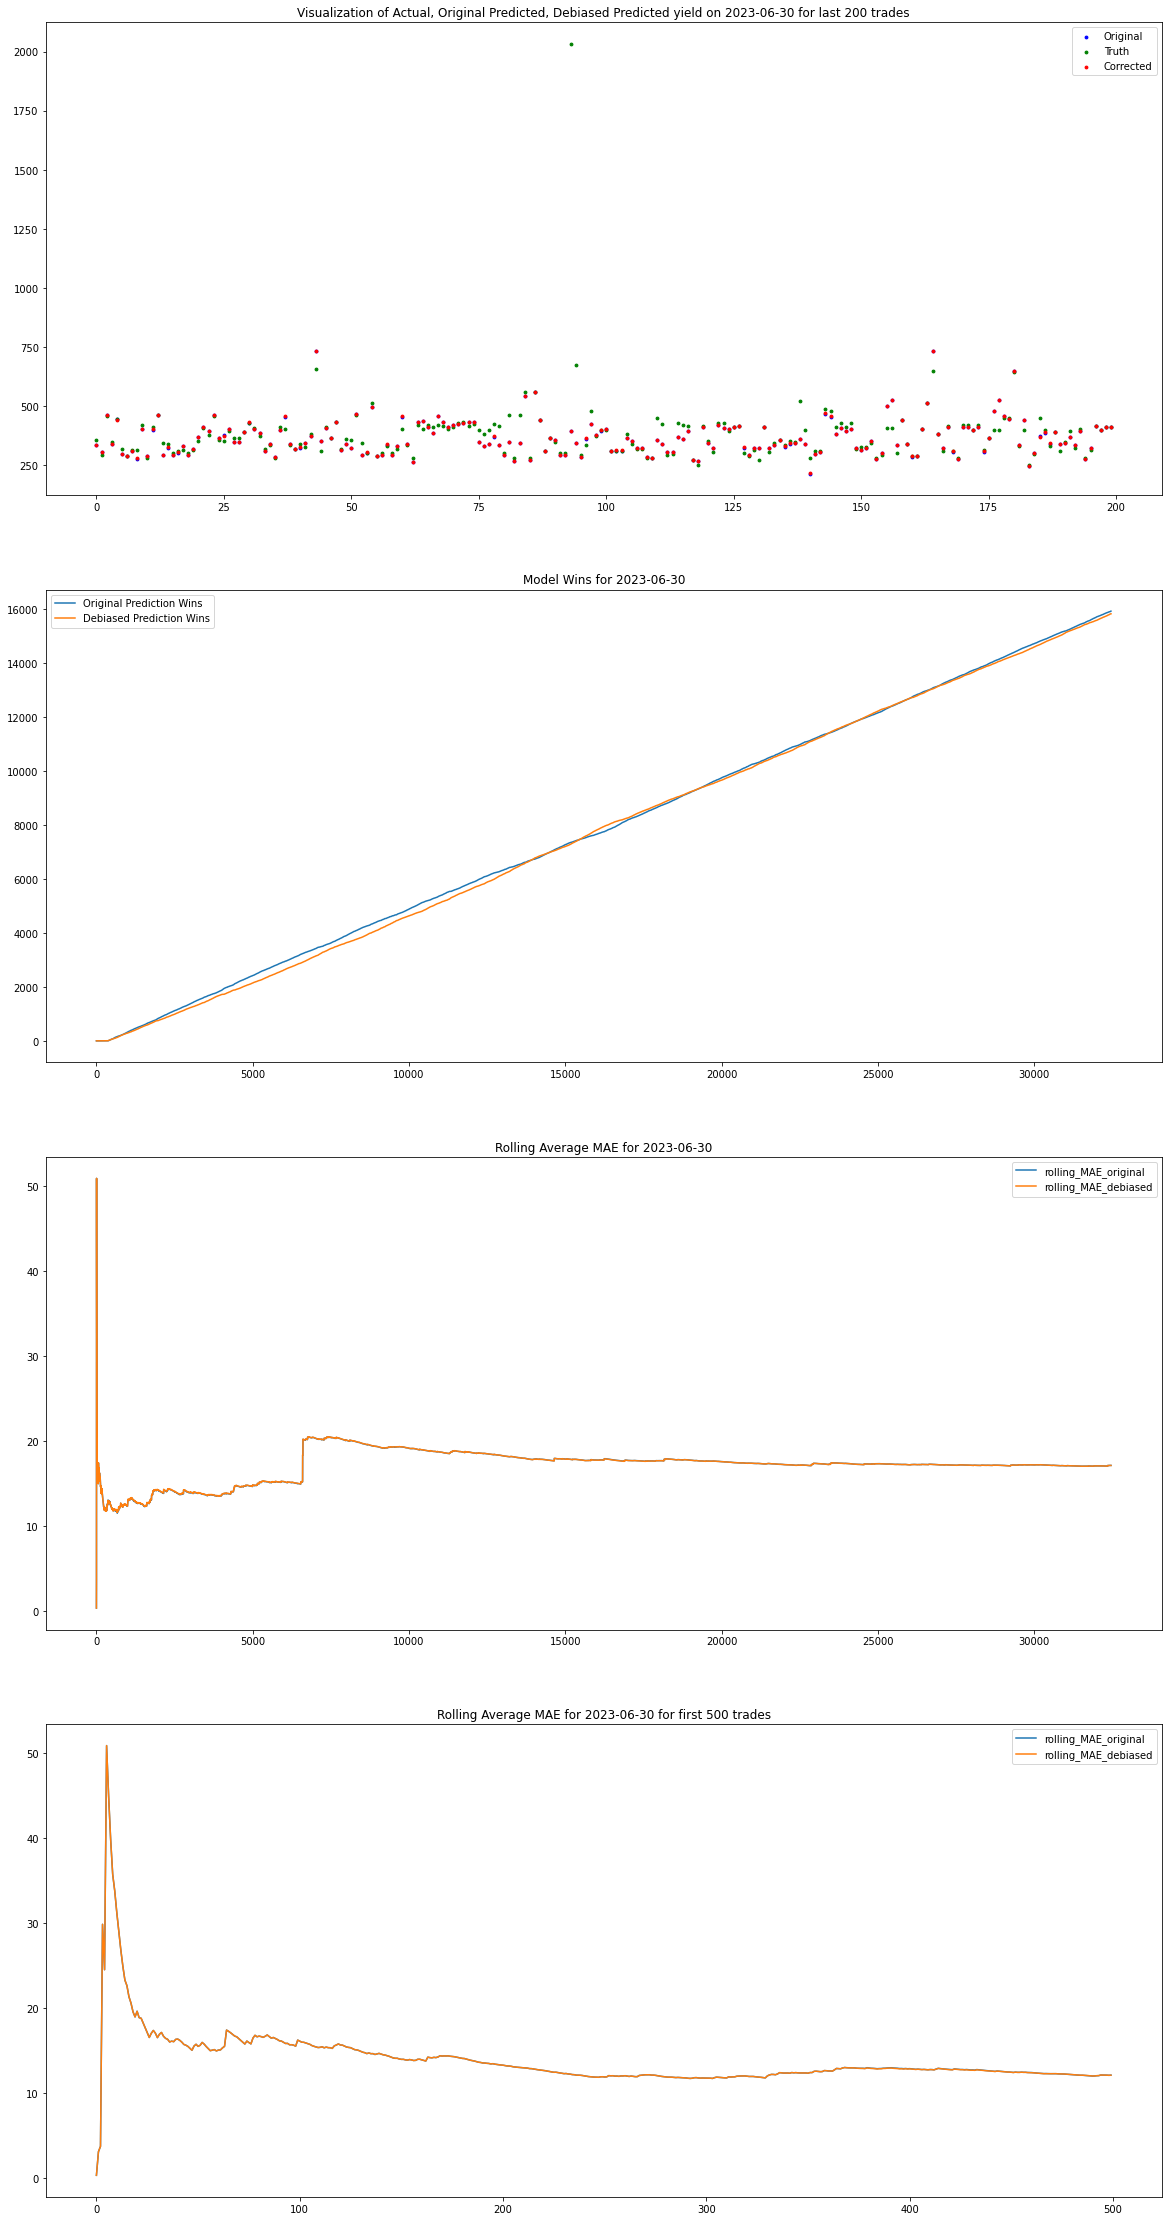

In [182]:
summary = analyze_debiasing_day('2023-06-30', trades_df_final, trades_df_final.bias, prediction_col='prediction', target_col='yield')

OVERALL ORIGINAL MAE: 10.09, OVERALL DEBIASED MAE: 10.09


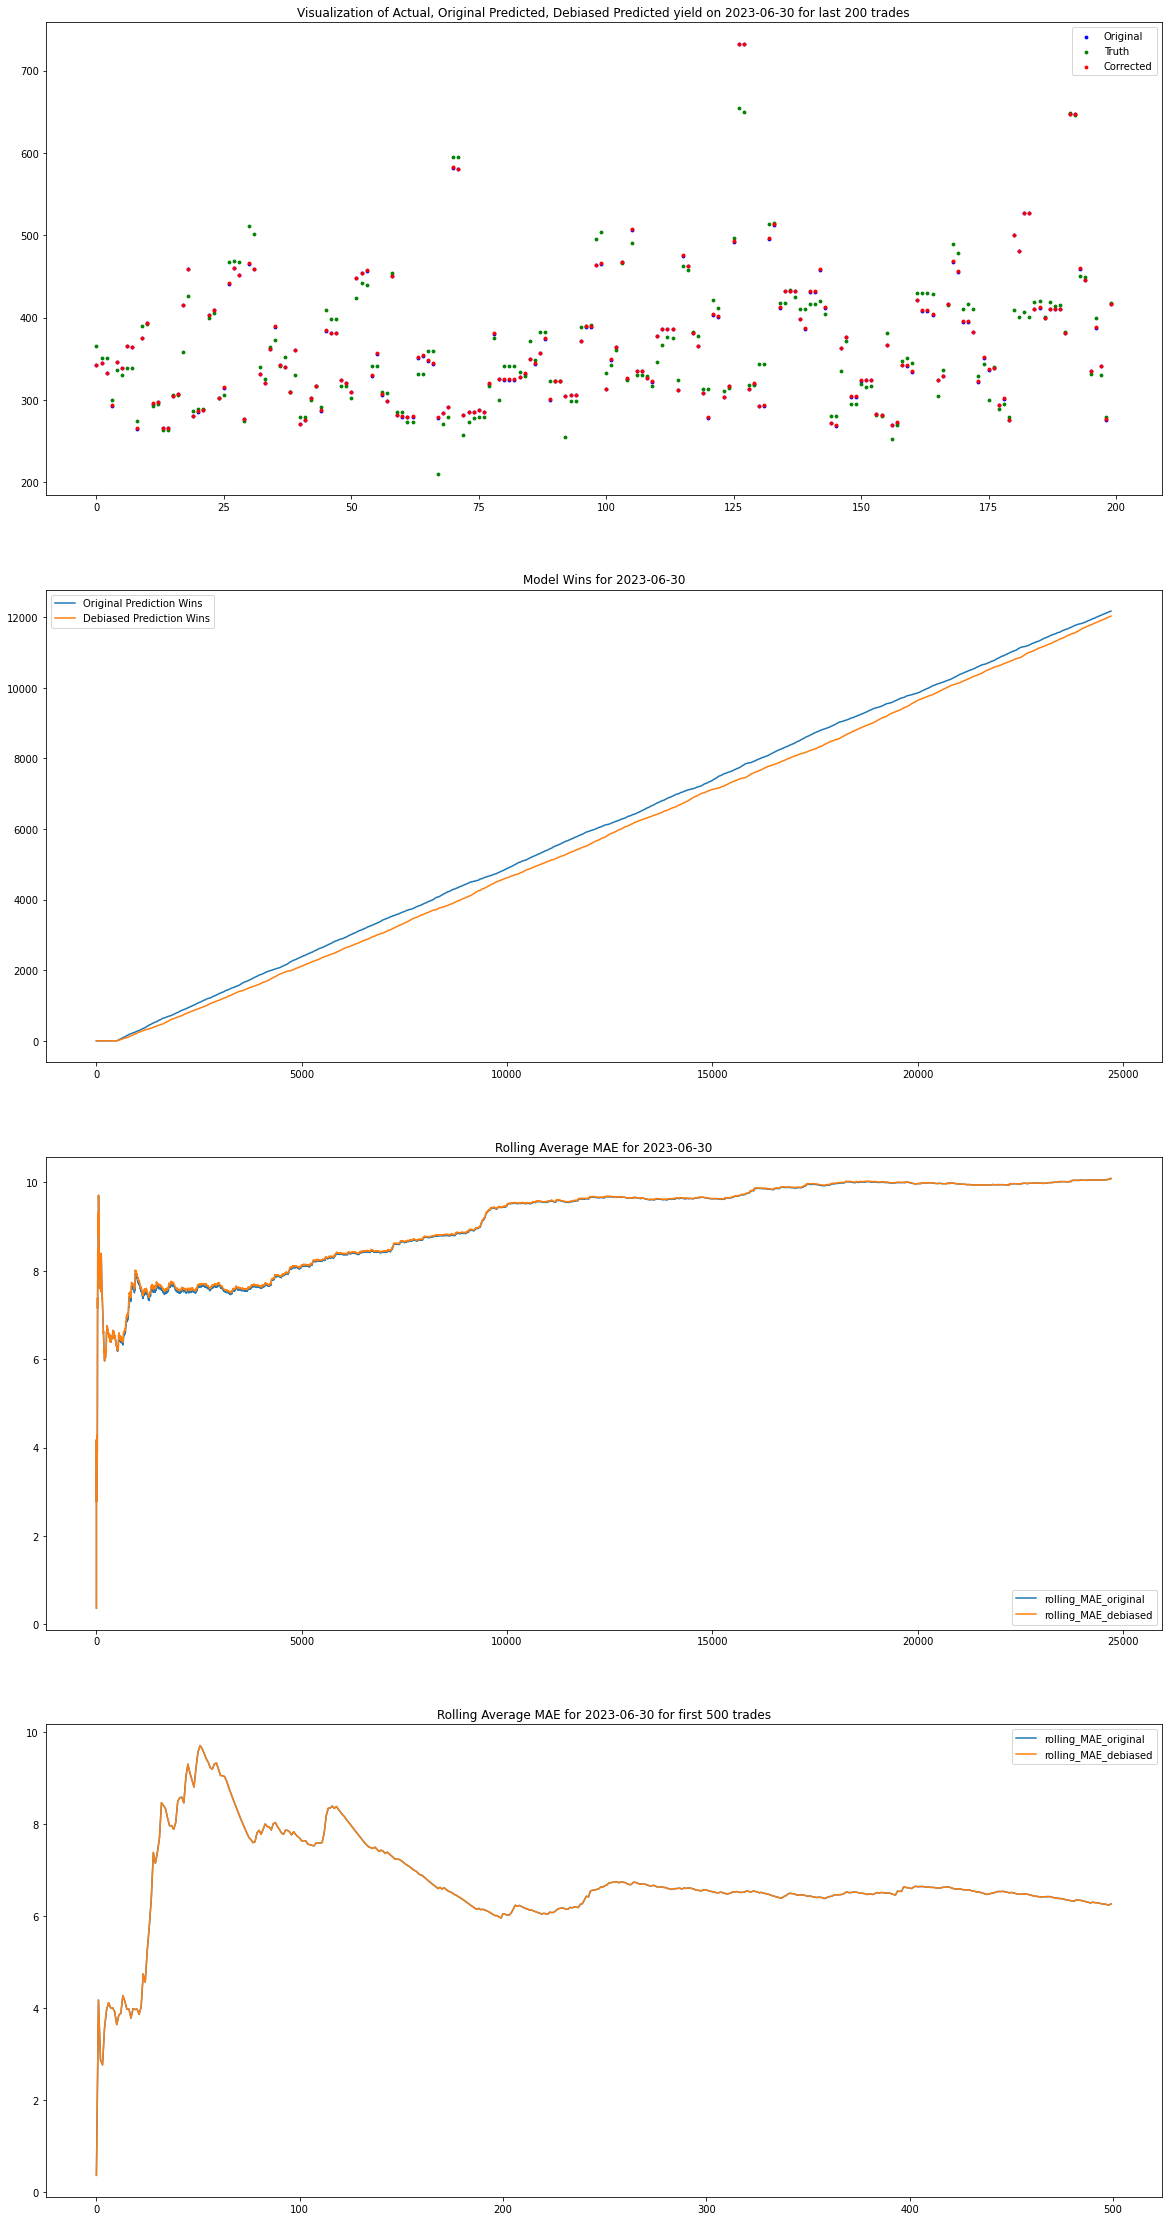

In [173]:
summary = analyze_debiasing_day('2023-06-30', data, data.bias, prediction_col='prediction', target_col='yield')

<AxesSubplot:>

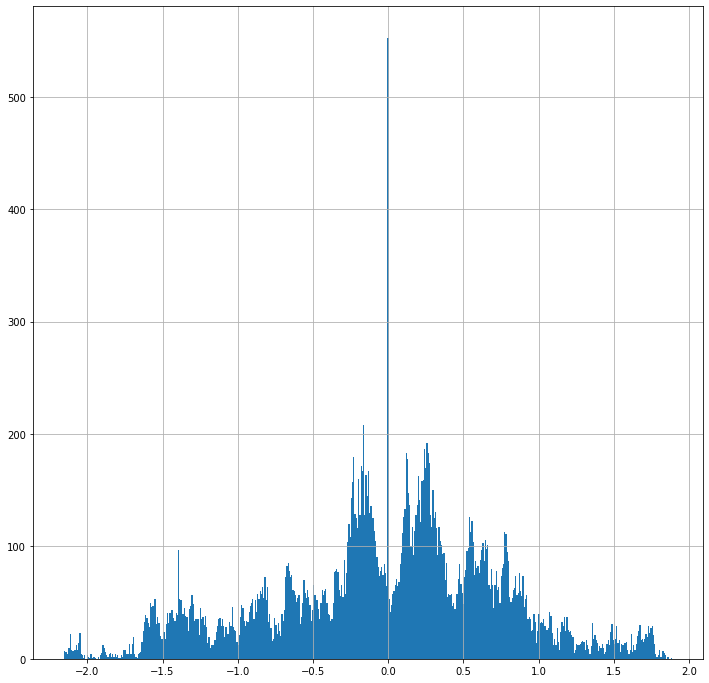

In [181]:
summary[['original_error', 'debiased_error']].diff(-1, axis=1).iloc[:,0].hist(bins=500, figsize=(12,12))

# Biases in Production

### Single date

In [45]:
biases = load_from_cloud_storage(f'gs://biases/bias_calculations_2023-07-06.pkl',  fs)
biases = list(biases)
biases[0] = biases[0][biases[0].trade_datetime >= '2023-07-06']
# biases[0] = biases[0].sort_values(by='trade_datetime', ascending = True)

bias_windows = []
for i in [500, 750, 1000, 2000]:
    %time x = simulate_weighted_average(biases[0], 'error', 'error', window_size = i, weighting_method='simple_average')
    bias_windows.append(bias_warm_start(x,WARM))
bias_df = pd.DataFrame(bias_windows).T
bias_df.columns =  [500, 750, 1000, 2000]
biases[0][bias_df.columns] = bias_df.values

Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 9.71 s, sys: 79.9 ms, total: 9.79 s
Wall time: 9.84 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 6.43 s, sys: 32 ms, total: 6.46 s
Wall time: 6.46 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 9.68 s, sys: 32 ms, total: 9.72 s
Wall time: 9.76 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 12.8 s, sys: 36 ms, total: 12.8 s
Wall time: 12.9 s


In [46]:
for col in bias_df.columns:
    print(f'Window {col}')
    debias_series(biases[0]['prediction'], biases[0]['yield'], bias_df[col])
    print('='*75)

Window 500
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.364, Corrected MAE: 10.458
Window 750
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.361, Corrected MAE: 10.456
Window 1000
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.360, Corrected MAE: 10.457
Window 2000
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.344, Corrected MAE: 10.455


In [47]:
biases[0].trade_datetime.min(), biases[0].trade_datetime.max()

(Timestamp('2023-07-06 06:00:01'), Timestamp('2023-07-06 15:11:53'))

OVERALL ORIGINAL MAE: 10.50, OVERALL DEBIASED MAE: 10.46


,cusip,trade_date,trade_type,prediction,yield,bias_correction,debiased_prediction,original_error,debiased_error
trade_datetime,,,,,,,,,
2023-07-06 06:00:01,342814DK3,2023-07-06,S,406.286737,399.8,0.000000,406.286737,-6.486737,-6.486737
2023-07-06 07:28:48,93878YBP3,2023-07-06,S,404.822757,400.0,0.000000,404.822757,-4.822757,-4.822757
2023-07-06 07:29:00,797661WP6,2023-07-06,D,317.040825,299.6,0.000000,317.040825,-17.440825,-17.440825
2023-07-06 07:29:00,785840JQ3,2023-07-06,D,365.347187,359.7,0.000000,365.347187,-5.647187,-5.647187
2023-07-06 07:29:57,785840JQ3,2023-07-06,S,327.921284,293.2,0.000000,327.921284,-34.721284,-34.721284
...,...,...,...,...,...,...,...,...,...
2023-07-06 15:11:38,672240VG0,2023-07-06,D,265.427318,271.0,0.434320,264.992998,5.572682,6.007002
2023-07-06 15:11:38,672240VG0,2023-07-06,P,266.437961,276.9,0.436222,266.001739,10.462039,10.898261
2023-07-06 15:11:42,20772KPZ6,2023-07-06,S,414.592558,432.1,0.506669,414.085888,17.507442,18.014112


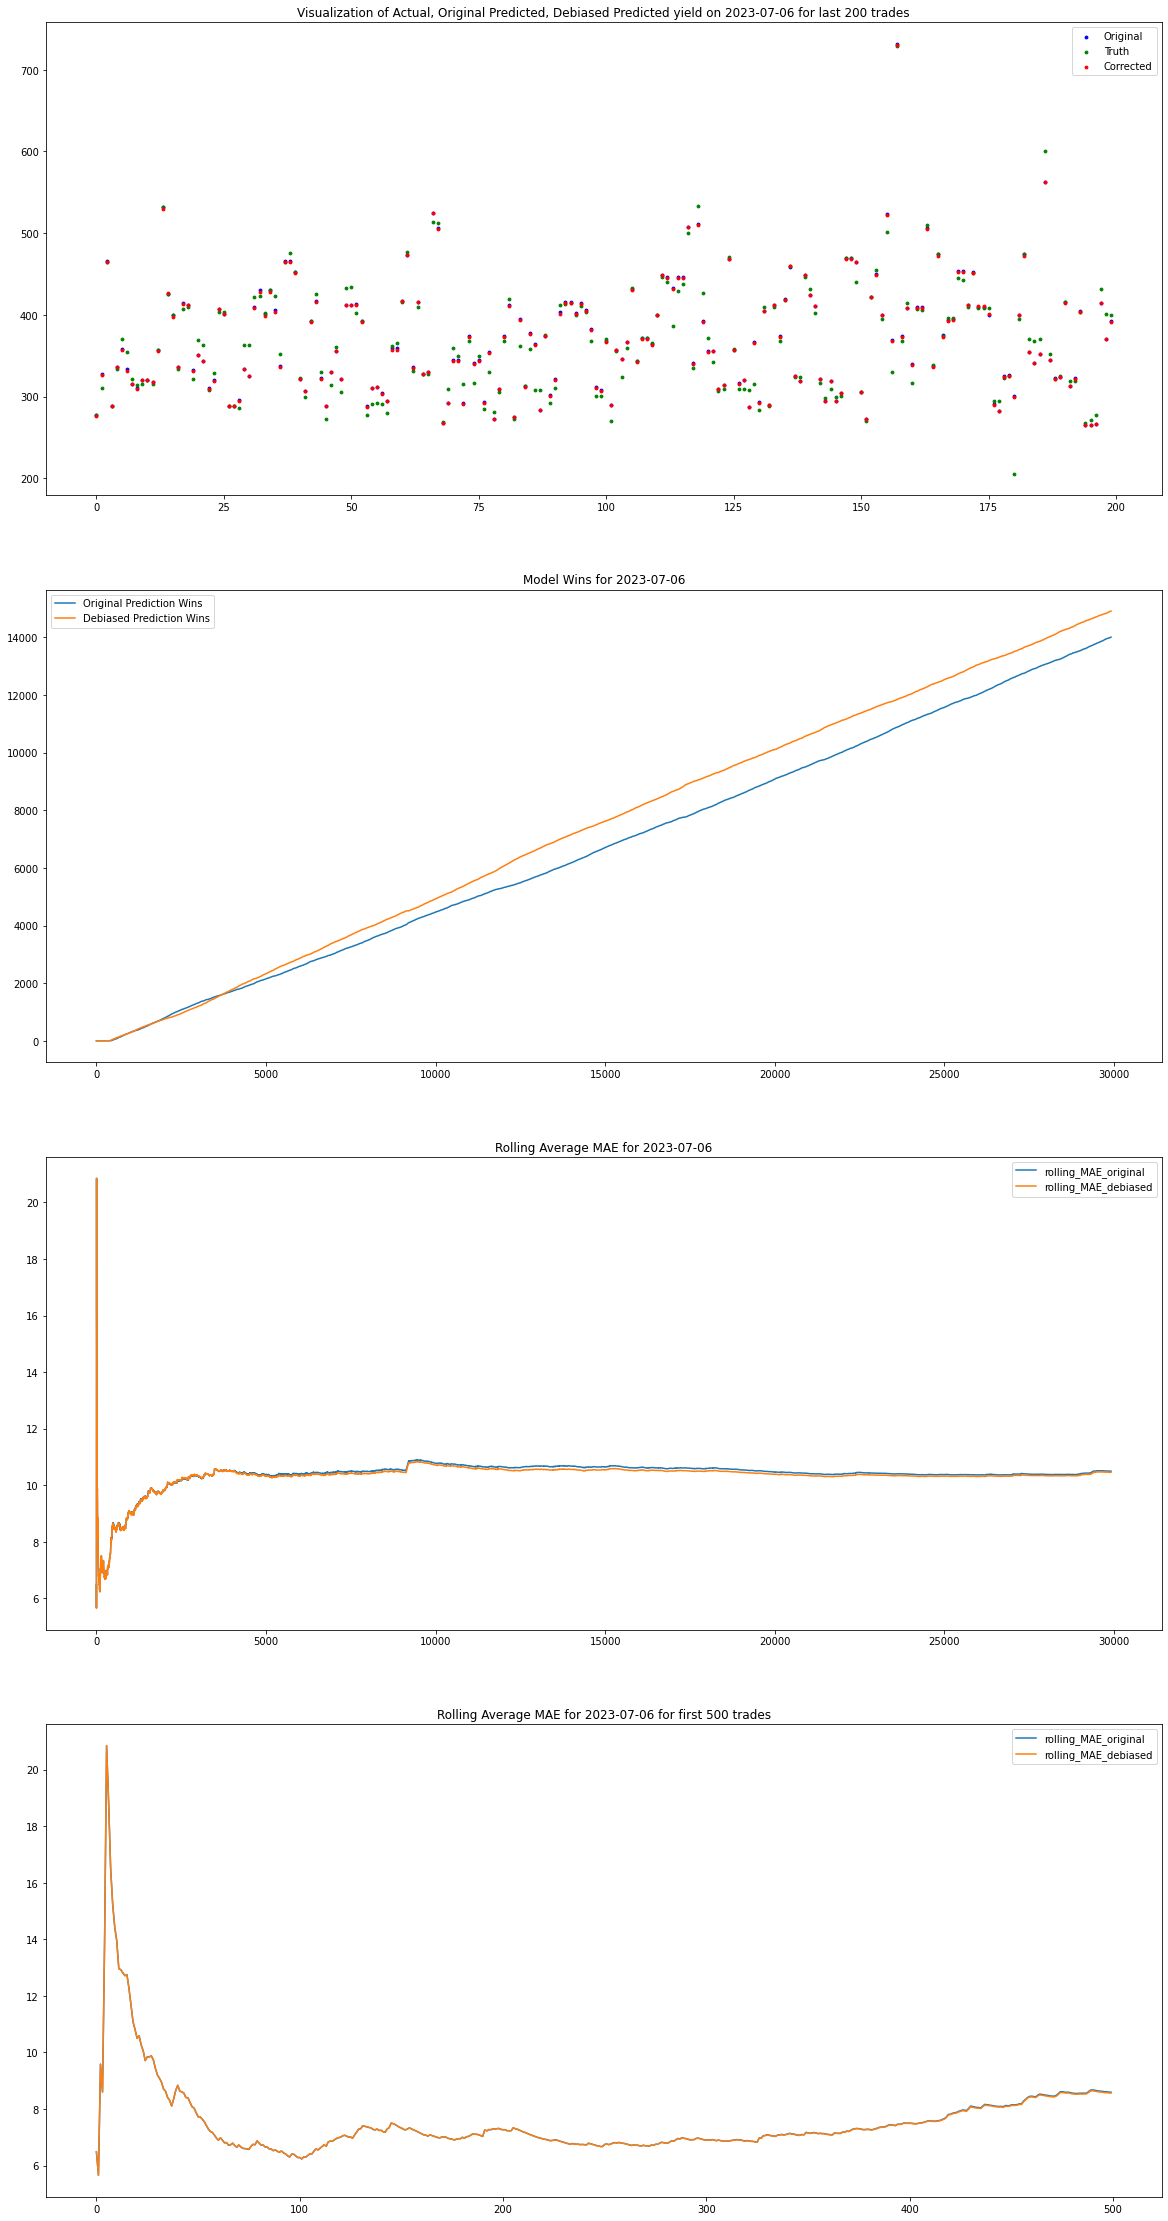

In [48]:
analyze_debiasing_day('2023-07-06', biases[0], biases[0][2000], prediction_col='prediction',
                                                            target_col='yield',
                                                            first_N_trades=500,
                                                            last_N_trades=200,
                                                            print_graphs=True,
                                                        )

<AxesSubplot:>

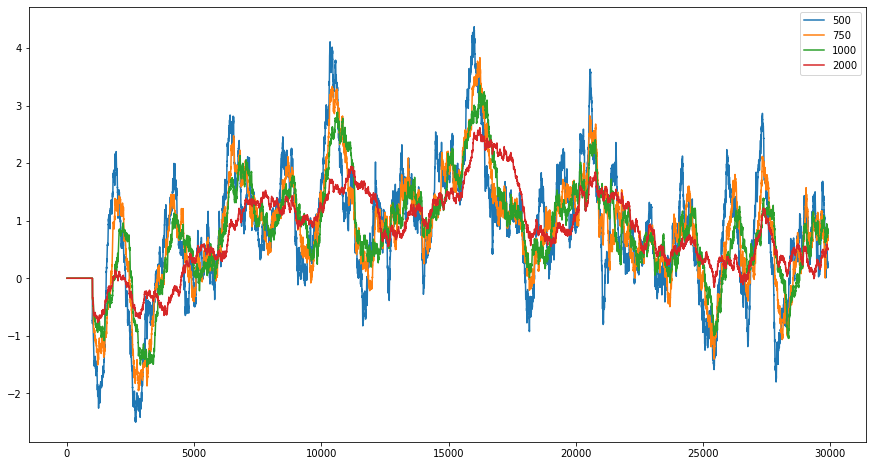

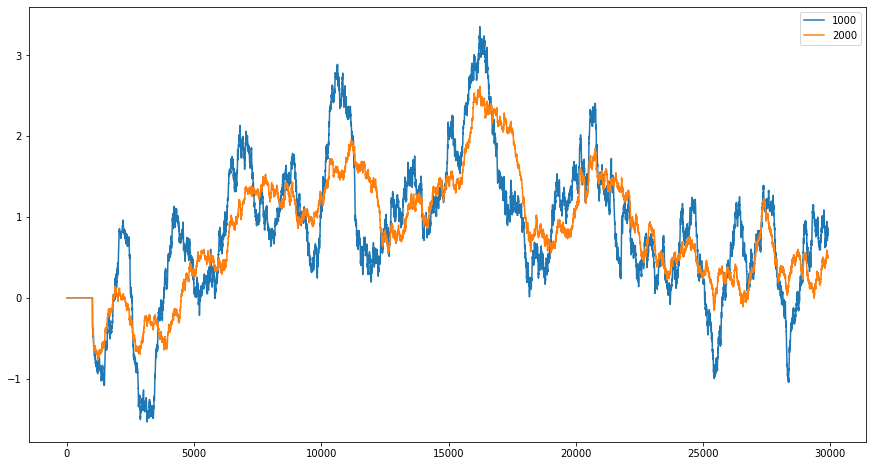

In [49]:
bias_df.plot(figsize=(15,8))
bias_df[[1000,2000]].plot(figsize=(15,8))

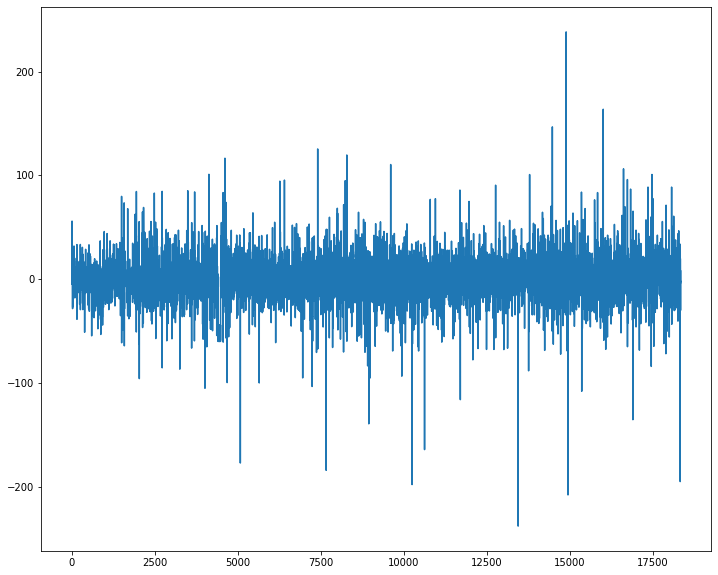

In [15]:
plt.figure(figsize=(12,10))
plt.plot(range(len(biases[0])), biases[0]['error'].rolling(1, min_periods = 1).mean())

- There is still unevenness in the bias calculations - what causes it to fluctuate up and down during the day?
- Why does debiasing only work halfway through the day?

There is still unevenness in the bias calculations - what causes it to fluctuate up and down during the day, for extended periods?

Consistently lowering biases imply a consistently lower (less positive) errors on a trade-by-trade basis.
Is this:
- reflective of a systemic shift in the market?
- led by individual cusips?

In [ ]:
temp = biases[0].sort_values(by='published_datetime', ascending=True)
x = bias_warm_start(simulate_weighted_average(temp, 'error', 'error', window_size = i, weighting_method='simple_average'), WARM)
debias_series(temp['prediction'], temp['yield'], x)

Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 1.696, Original MAE: 9.367, Corrected bias: 0.314, Corrected MAE: 9.321


OVERALL ORIGINAL MAE: 9.37, OVERALL DEBIASED MAE: 9.32


,trade_date,trade_datetime,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,error,...,days_to_refund,bias,500,750,1000,2000,bias_correction,debiased_prediction,original_error,debiased_error
0,2023-07-05,2023-07-05 06:00:01,2023-07-05 06:45:15,S,I,10607UEU9,20000.0,424.9,426.409962,1.509962,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,426.409962,-1.509962,-1.509962
1,2023-07-05,2023-07-05 06:00:01,2023-07-05 06:45:15,S,I,10607UEU9,20000.0,424.9,426.409962,1.509962,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,426.409962,-1.509962,-1.509962
2,2023-07-03,2023-07-03 09:30:47,2023-07-05 06:45:18,S,I,717893W72,4475000.0,405.0,404.298826,-0.701174,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,404.298826,0.701174,0.701174
3,2023-07-03,2023-07-03 09:30:47,2023-07-05 06:45:18,S,I,717893W72,4475000.0,405.0,404.298826,-0.701174,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,404.298826,0.701174,0.701174
9,2023-07-05,2023-07-05 07:34:00,2023-07-05 07:34:22,S,I,59447TYG2,100000.0,412.0,399.831173,-12.168827,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,399.831173,12.168827,12.168827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40288,2023-07-05,2023-07-05 13:59:39,2023-07-05 14:00:01,P,I,59333PS82,10000.0,339.5,335.180147,-4.319853,...,0,4.052028,2.282188,2.237457,2.415663,2.708724,2.743260,332.436887,4.319853,7.063113
40287,2023-07-05,2023-07-05 13:59:49,2023-07-05 14:00:01,P,I,362762PE0,15000.0,342.3,360.343554,18.043554,...,0,4.066527,2.272631,2.199650,2.396659,2.695176,2.743372,357.600182,-18.043554,-15.300182
40290,2023-07-05,2023-07-05 13:59:40,2023-07-05 14:00:01,P,I,796269H35,10000.0,301.6,302.436114,0.836114,...,0,4.009275,2.264651,2.229995,2.363793,2.692414,2.757002,299.679113,-0.836114,1.920887
40289,2023-07-05,2023-07-05 13:59:39,2023-07-05 14:00:01,P,I,97712DM52,10000.0,343.7,333.421044,-10.278956,...,0,4.036872,2.228956,2.208352,2.412104,2.710674,2.762009,330.659035,10.278956,13.040965


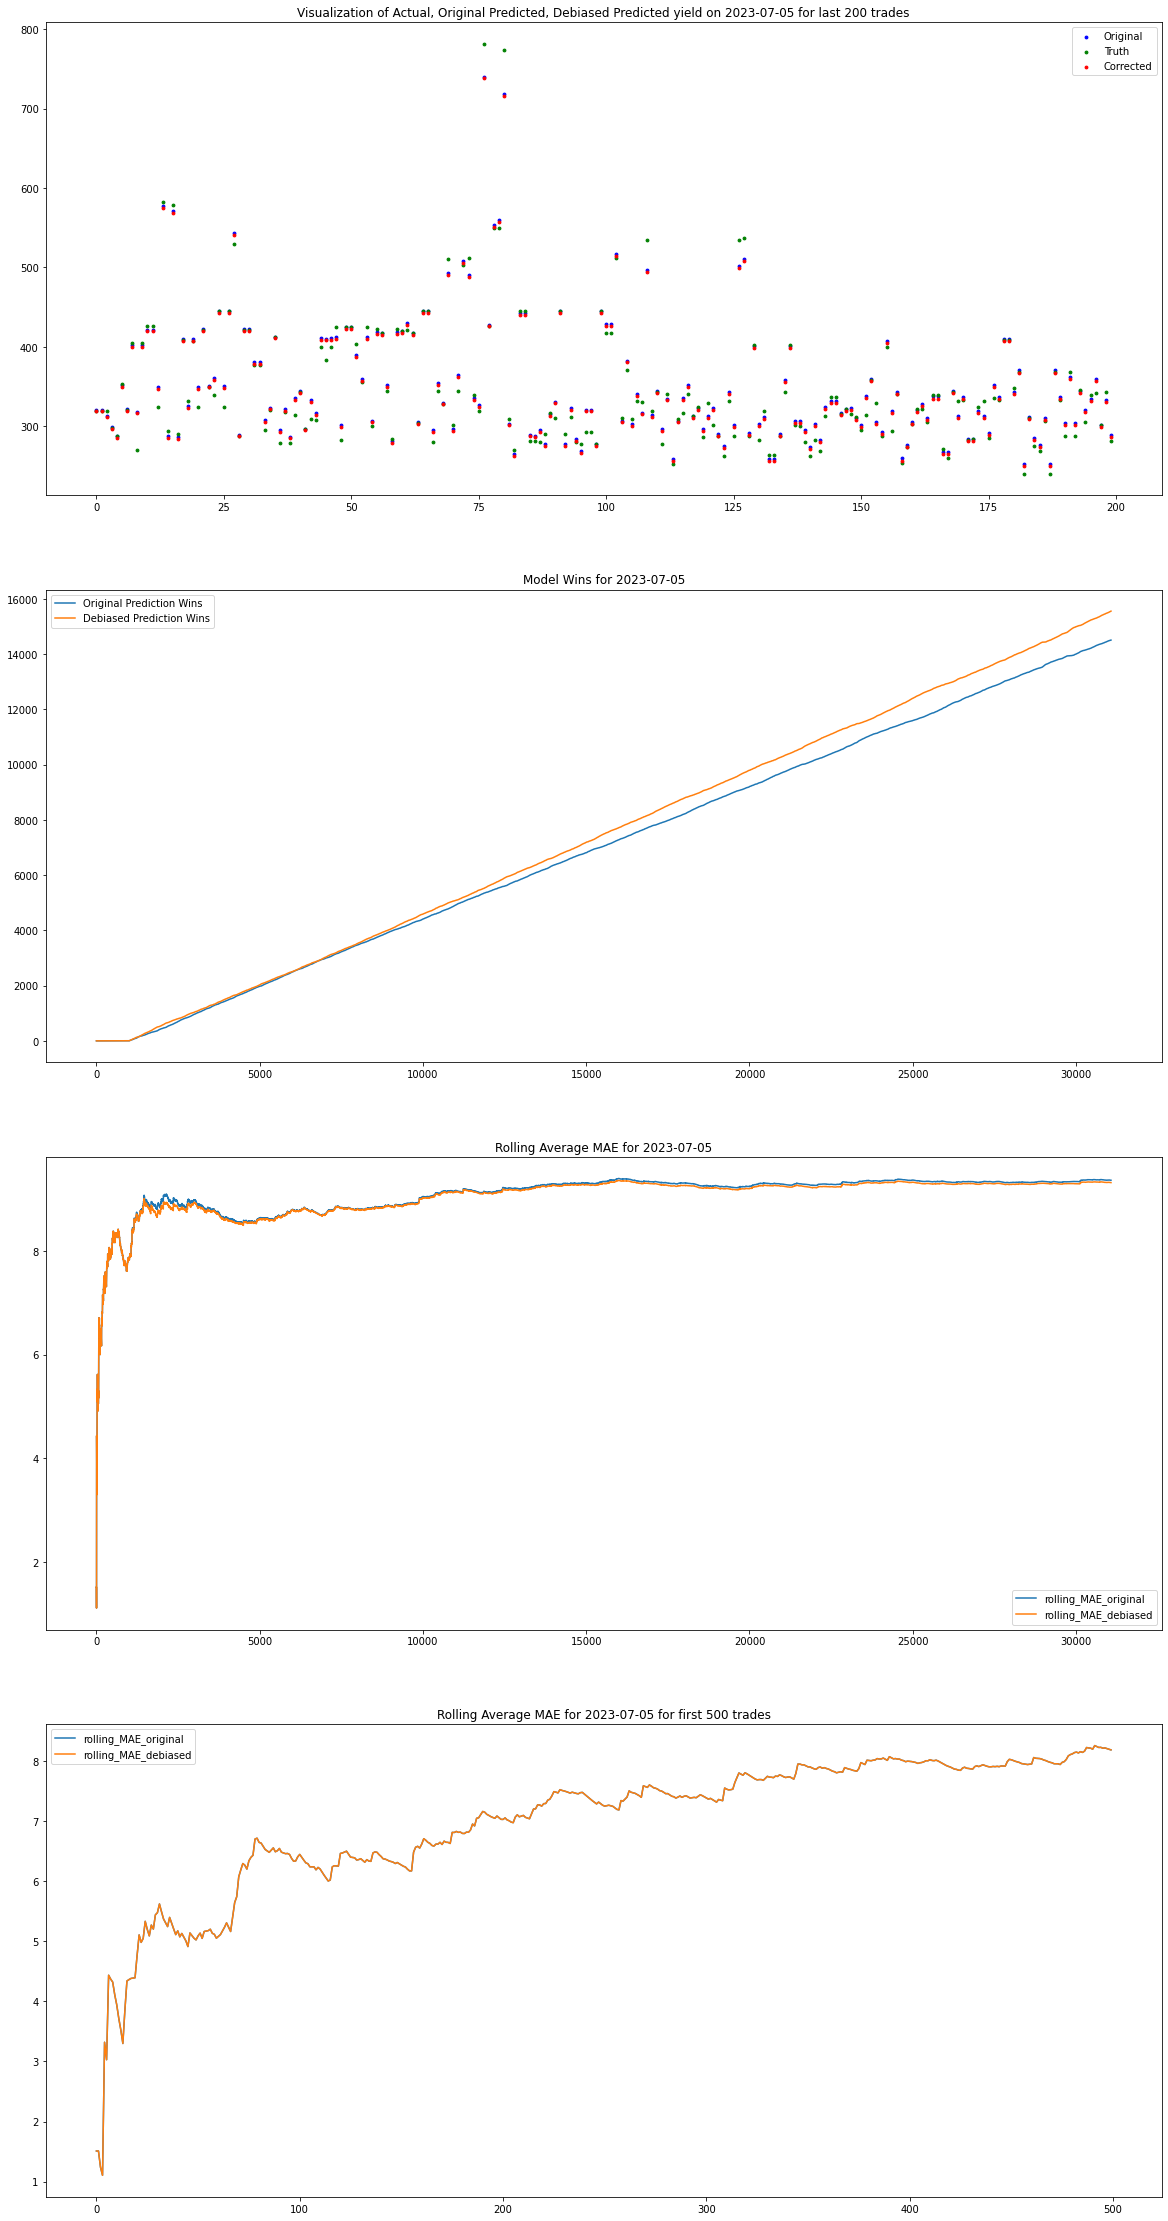

In [ ]:
analyze_debiasing_day('2023-07-05', temp, x, prediction_col='prediction',
                                                            target_col='yield',
                                                            first_N_trades=500,
                                                            last_N_trades=200,
                                                            print_graphs=True,
                                                        )

<AxesSubplot:>

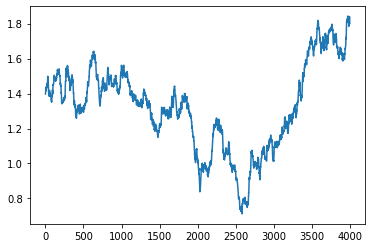

In [ ]:
#we want to study this area specifically
L = 12000
R = 16000

biases[0].iloc[L:R][2000].reset_index(drop=True).plot()

<AxesSubplot:xlabel='hour,minute'>

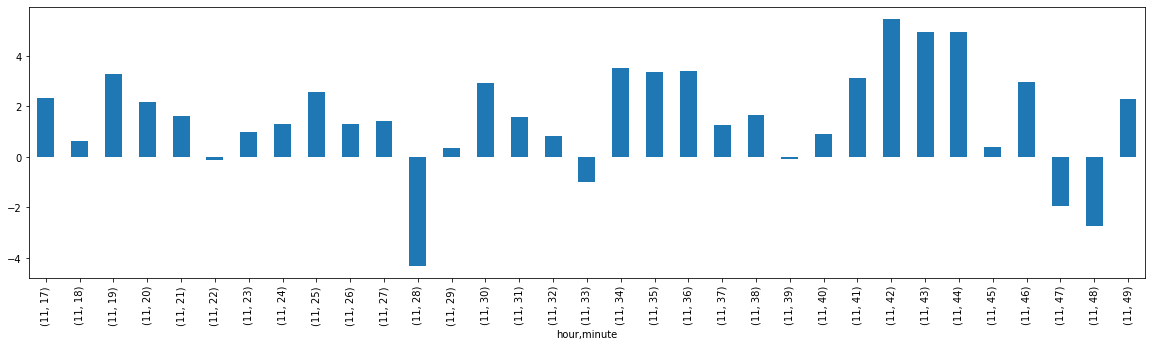

In [ ]:
temp = biases[0].iloc[L:R]
temp = temp[abs(temp.error) <= 35]                       
temp['hour'] = temp['trade_datetime'].dt.hour
temp['minute'] = temp['trade_datetime'].dt.minute
temp.groupby(['hour','minute']).error.mean().plot(kind='bar', figsize=(20, 5))

<AxesSubplot:xlabel='hour,minute'>

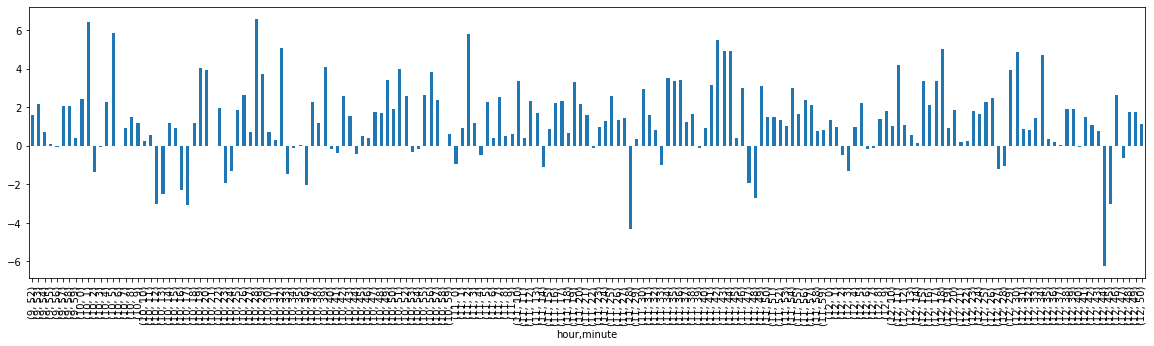

In [ ]:
temp = biases[0].iloc[L-8000:R+8000]
temp = temp[abs(temp.error) <= 35]                       
temp['hour'] = temp['trade_datetime'].dt.hour
temp['minute'] = temp['trade_datetime'].dt.minute
temp.groupby(['hour','minute']).error.mean().plot(kind='bar', figsize=(20, 5))

<AxesSubplot:xlabel='hour,minute'>

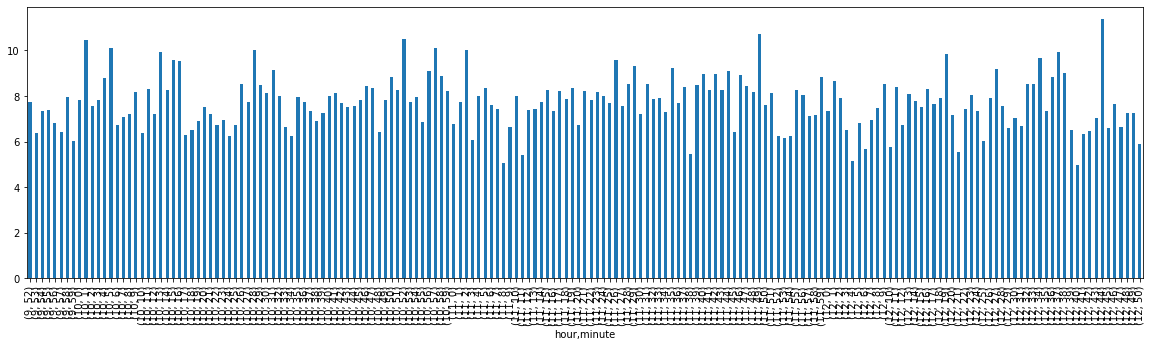

In [ ]:
lambda_func = lambda x: x.apply(np.abs).mean()
temp.groupby(['hour','minute']).error.apply(lambda_func).plot(kind='bar', figsize=(20, 5))

In [ ]:
temp.set_index('trade_datetime').loc['2023-07-05 11:40':'2023-07-05 11:45'].sort_values(by='error').head(15)

,trade_date,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,error,next_call_date,...,days_to_call,days_to_maturity,days_to_refund,bias,500,750,1000,2000,hour,minute
trade_datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-05 11:44:01,2023-07-05,2023-07-05 11:44:23,D,I,721876UB4,10000.0,368.5,338.109852,-30.390148,None,...,0,714,0,2.966077,2.600542,2.476925,2.467827,1.695500,11,44
2023-07-05 11:45:38,2023-07-05,2023-07-05 11:45:59,S,I,57584YER6,15000.0,403.3,376.250535,-27.049465,2028-07-01,...,1794,7554,0,2.789950,3.093543,2.565906,2.507109,1.673445,11,45
2023-07-05 11:40:57,2023-07-05,2023-07-05 11:41:27,S,I,797398EJ9,30000.0,542.5,516.706811,-25.793189,None,...,0,1118,0,2.199768,1.575363,1.561717,1.522306,1.246313,11,40
2023-07-05 11:40:57,2023-07-05,2023-07-05 11:41:27,S,I,797398EJ9,30000.0,542.5,516.706811,-25.793189,None,...,0,1118,0,2.163416,1.632981,1.617444,1.550849,1.259297,11,40
2023-07-05 11:40:34,2023-07-05,2023-07-05 11:40:48,S,I,57584YPW3,15000.0,415.0,389.559883,-25.440117,None,...,0,1794,0,2.113270,1.724013,1.686698,1.663267,1.264583,11,40
2023-07-05 11:41:46,2023-07-05,2023-07-05 11:41:57,S,I,746189QU6,25000.0,511.1,488.856421,-22.243579,NaT,...,0,2514,0,-0.445539,1.792873,2.156266,1.832723,1.448712,11,41
2023-07-05 11:41:46,2023-07-05,2023-07-05 11:41:57,S,I,746189QU6,25000.0,511.1,488.856421,-22.243579,None,...,0,2514,0,-0.483937,1.711838,2.091830,1.787244,1.422275,11,41
2023-07-05 11:43:14,2023-07-05,2023-07-05 11:43:20,S,I,60416HU51,25000.0,331.0,309.054170,-21.945830,None,...,0,984,0,0.278896,2.447751,2.323059,2.236100,1.639322,11,43
2023-07-05 11:45:32,2023-07-05,2023-07-05 11:46:20,D,I,73358WZH0,150000.0,352.7,333.516144,-19.183856,2025-10-15,...,818,6578,0,-0.696718,3.149851,2.413414,2.475475,1.681533,11,45


In [ ]:
temp.set_index('trade_datetime').loc['2023-07-05 11:40':'2023-07-05 11:45'].sort_values(by='error').tail(15)

,trade_date,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,error,next_call_date,...,days_to_call,days_to_maturity,days_to_refund,bias,500,750,1000,2000,hour,minute
trade_datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-05 11:41:01,2023-07-05,2023-07-05 11:41:37,D,I,544495VX9,50000000.0,490.0,515.210593,25.210593,NaT,...,0,1434,0,2.120348,1.552896,1.737864,1.527748,1.254315,11,41
2023-07-05 11:43:10,2023-07-05,2023-07-05 11:43:44,D,I,7087963X3,50000.0,376.0,401.974125,25.974125,2025-10-01,...,804,1524,0,3.077215,2.255206,2.286440,2.140179,1.610729,11,43
2023-07-05 11:43:10,2023-07-05,2023-07-05 11:43:44,D,I,7087963X3,50000.0,376.0,401.974125,25.974125,2025-10-01,...,804,1524,0,3.103776,2.299777,2.302573,2.164713,1.625123,11,43
2023-07-05 11:44:47,2023-07-05,2023-07-05 11:45:18,D,I,57652TAV9,10000.0,366.0,392.579875,26.579875,None,...,0,1914,0,2.851385,2.826930,2.711511,2.810939,1.712177,11,44
2023-07-05 11:44:47,2023-07-05,2023-07-05 11:45:18,D,I,57652TAV9,10000.0,366.0,392.579875,26.579875,NaT,...,0,1914,0,2.839313,2.880958,2.747581,2.843987,1.731146,11,44
2023-07-05 11:40:31,2023-07-05,2023-07-05 11:40:48,D,I,57584XYC9,50000.0,326.1,352.833299,26.733299,2026-07-15,...,1088,4688,0,1.848689,1.562440,1.698849,1.649030,1.270174,11,40
2023-07-05 11:42:11,2023-07-05,2023-07-05 11:42:31,S,I,809454BX8,25000.0,301.9,329.025059,27.125059,2029-07-15,...,2168,3248,0,2.519705,1.983399,2.086880,1.737640,1.468844,11,42
2023-07-05 11:45:34,2023-07-05,2023-07-05 11:45:41,S,I,57583U6R4,25000.0,376.6,405.524368,28.924368,2025-07-01,...,714,7554,0,2.814366,3.048598,2.396666,2.450974,1.656477,11,45
2023-07-05 11:45:34,2023-07-05,2023-07-05 11:45:41,S,I,57583U6R4,25000.0,376.6,405.524368,28.924368,2025-07-01,...,714,7554,0,2.837779,2.994878,2.359771,2.433546,1.642260,11,45


#### Debiasing for single cusips within a series of trades

In [333]:
for window in [500, 750, 1000, 2000]:
    debias_series(df['prediction'], df['yield'], df[window])

Original bias: 1.769, Original MAE: 9.607, Corrected bias: 0.216, Corrected MAE: 9.551
Original bias: 1.769, Original MAE: 9.607, Corrected bias: 0.211, Corrected MAE: 9.543
Original bias: 1.769, Original MAE: 9.607, Corrected bias: 0.208, Corrected MAE: 9.543
Original bias: 1.769, Original MAE: 9.607, Corrected bias: 0.197, Corrected MAE: 9.549


In [54]:
for i in range(len(biases[0])+1, len(biases[0])+101):
    biases[0].loc[i] = biases[0].loc[13163]
    
biases[0].sort_values(by='trade_datetime', inplace=True, ascending=True)  
biases[0]['bias_test'] = bias_warm_start(simulate_weighted_average(biases[0], 
                                                                                                     weighting_col = 'error', 
                                                                                                     error_col = 'error', 
                                                                                                     groupby_cols=['trade_date'], 
                                                                                                     window_size=2000, 
                                                                                                     weighting_method='simple_average', 
                                                                                                     mask_large=35),
                                                                                              WARM)
debias_series(biases[0]['prediction'], biases[0]['yield'], biases[0]['bias_test'])
temp = biases[0][biases[0].cusip!='8014952M3']
debias_series(temp['prediction'], temp['yield'], temp['bias_test'])

Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.491, Original MAE: 10.492, Corrected bias: -0.359, Corrected MAE: 10.438
Original bias: 0.490, Original MAE: 10.492, Corrected bias: -0.360, Corrected MAE: 10.437


In [55]:
def combine(df):
    # average_error = df.error.mean()
    temp = df.iloc[0]
    temp['error'] = df.error.mean()
    return temp

for window in [2000]:
    print(f'Window {window}')
    # window = 1000
    df = biases[0].sort_values(by='trade_datetime', ascending=True)
    df['key'] = range(len(df))
    df['hour'] = df['trade_datetime'].dt.hour
    df['minute'] = df['trade_datetime'].dt.minute
    unique_df = df.groupby(['hour','minute','cusip']).apply(combine)
    unique_df['bias_unique'] = bias_warm_start(simulate_weighted_average(unique_df, 'error', 'error', window_size=window, weighting_method='simple_average'), WARM)
    df = pd.merge(df, 
             unique_df[['bias_unique','key']].reset_index(drop=True),
             on = 'key',
             how='outer'
            )
    df.bias_unique = df.bias_unique.ffill()
    debias_series(df['prediction'], df['yield'], df.bias_unique.fillna(0))
    print('='*75)
    
temp = df[df.cusip!='8014952M3']
debias_series(temp['prediction'], temp['yield'], temp['bias_unique'])

Window 2000
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.491, Original MAE: 10.492, Corrected bias: -0.165, Corrected MAE: 10.454
Original bias: 0.490, Original MAE: 10.492, Corrected bias: -0.166, Corrected MAE: 10.453


In [51]:
for window in [500, 750, 1000, 2000]:
    print(f'Window {window}')
    # window = 1000
    df = biases[0].sort_values(by='trade_datetime', ascending=True)
    df['key'] = range(len(df))
    df['hour'] = df['trade_datetime'].dt.hour
    df['minute'] = df['trade_datetime'].dt.minute
    unique_df = df.groupby(['hour','minute','cusip']).apply(lambda x: x.iloc[0])
    unique_df['bias_unique'] = bias_warm_start(simulate_weighted_average(unique_df, 'error', 'error', window_size=window, weighting_method='simple_average'), WARM)
    df = pd.merge(df, 
             unique_df[['bias_unique','key']].reset_index(drop=True),
             on = 'key',
             how='outer'
            )
    df.bias_unique = df.bias_unique.bfill()
    debias_series(df['prediction'], df['yield'], df.bias_unique.fillna(0))
    print('='*75)

Window 500
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.287, Corrected MAE: 10.449
Window 750
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.275, Corrected MAE: 10.450
Window 1000
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.263, Corrected MAE: 10.449
Window 2000
Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 0.466, Original MAE: 10.497, Corrected bias: -0.225, Corrected MAE: 10.468


<AxesSubplot:>

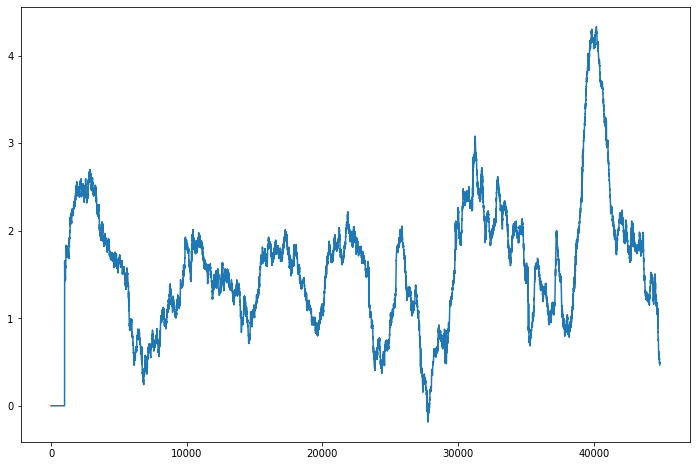

In [334]:
df[2000].plot(figsize=(12,8))

<AxesSubplot:>

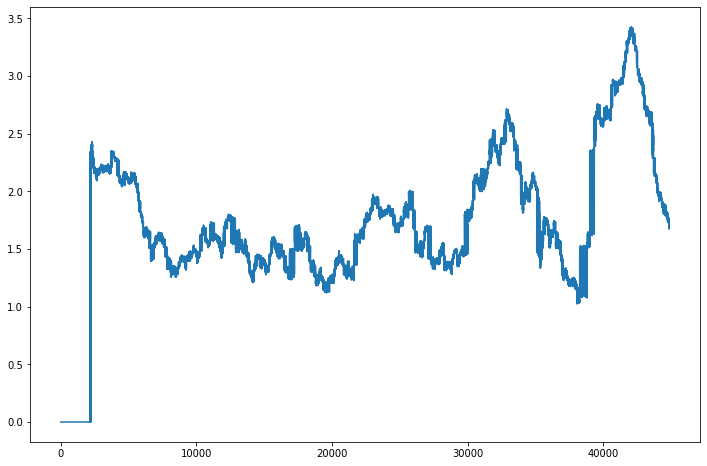

In [335]:
df.bias_unique.plot(figsize=(12,8))

<AxesSubplot:>

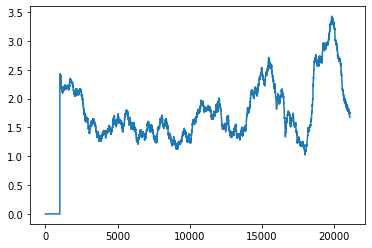

In [381]:
unique_df.reset_index(drop=True).bias_unique.plot()

trade_date      trade_datetime  published_datetime  \
hour minute cusip                                                          
15   51     66285WWE2 2023-07-05 2023-07-05 15:51:00 2023-07-05 15:52:56   
     9      866382GG3 2023-07-05 2023-07-05 15:09:11 2023-07-05 15:09:21   
16   10     786073BS4 2023-07-05 2023-07-05 16:10:42 2023-07-05 16:10:49   
14   36     6461395W1 2023-07-05 2023-07-05 14:36:56 2023-07-05 14:37:06   
     48     529063RR2 2023-07-05 2023-07-05 14:48:04 2023-07-05 14:48:27   
...                          ...                 ...                 ...   
13   41     031358BR4 2023-07-05 2023-07-05 13:41:34 2023-07-05 13:41:54   
     46     839423CJ7 2023-07-05 2023-07-05 13:46:01 2023-07-05 13:46:10   
15   31     546399EP7 2023-07-05 2023-07-05 15:31:17 2023-07-05 15:31:23   
     26     97705MCZ6 2023-07-05 2023-07-05 15:26:50 2023-07-05 15:26:57   
     43     13080SER1 2023-07-05 2023-07-05 15:43:30 2023-07-05 15:43:53   

                      trade_type transaction_type      cusip  par_traded  \
hour minute cusip                                                          
15   51     66285WWE2          S                I  66285WWE2     15000.0   
     9      866382GG3          S                I  866382GG3     40000.0   
16   10     786073BS4          S                I  786073BS4     20000.0   
14   36     6461395W1          S                I  6461395W1     50000.0   
     48     529063RR2          P                I  529063RR2  50000000.0   
...                          ...              ...        ...         ...   
13   41     031358BR4          P                I  031358BR4     90000.0   
     46     839423CJ7          S                I  839423CJ7     25000.0   
15   31     546399EP7          P                I  546399EP7     20000.0   
     26     97705MCZ6          S                I  97705MCZ6     50000.0   
     43     13080SER1          S                I  13080SER1    100000.0   

                       yield  prediction      error  ...      bias       500  \
hour minute cusip                                    ...                       
15   51     66285WWE2  314.8  279.830978 -34.969022  ...  3.461282  0.425540   
     9      866382GG3  366.6  331.663247 -34.936753  ... -0.000093 -0.349632   
16   10     786073BS4  382.8  347.937609 -34.862391  ...  2.714125  1.827981   
14   36     6461395W1  350.4  315.571821 -34.828179  ...  0.206174  3.074222   
     48     529063RR2  343.0  308.199890 -34.800110  ...  2.835227  3.248855   
...                      ...         ...        ...  ...       ...       ...   
13   41     031358BR4  383.7  418.383993  34.683993  ...  2.181498  0.011895   
     46     839423CJ7  249.0  283.868233  34.868233  ...  1.722059  2.527340   
15   31     546399EP7  306.6  341.506039  34.906039  ...  2.864249  2.048469   
     26     97705MCZ6  254.9  289.897004  34.997004  ...  2.788247  1.284141   
     43     13080SER1  280.1  315.099393  34.999393  ...  3.076562  2.705867   

                            750      1000      2000  hour  minute    key  \
hour minute cusip                                                          
15   51     66285WWE2  1.662218  1.856978  1.925628    15      51  42449   
     9      866382GG3 -0.149250  0.378848  0.984011    15       9  37721   
16   10     786073BS4  1.479563  1.640040  1.508219    16      10  44222   
14   36     6461395W1  2.858342  2.858361  1.751717    14      36  34844   
     48     529063RR2  2.798173  0.675967  1.530411    14      48  35982   
...                         ...       ...       ...   ...     ...    ...   
13   41     031358BR4  0.495707  0.908449  0.874630    13      41  29332   
     46     839423CJ7  1.297502  1.498490  1.383374    13      46  29652   
15   31     546399EP7  1.982377  1.884200  3.455208    15      31  40708   
     26     97705MCZ6  2.042094  2.532267  4.125503    15      26  40263   
     43     13080SER1  2.495288  2.035490  1.948354    15      43  41759   

              

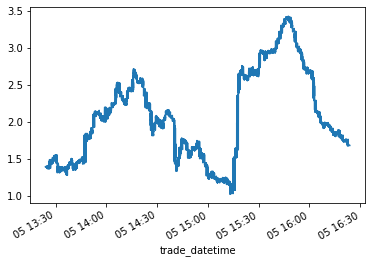

In [382]:
temp = unique_df.iloc[13000:]
temp = temp[abs(temp.error) <= 35]
temp.set_index('trade_datetime').bias_unique.plot()
display(temp.sort_values(by='error'))

Something happens at 15:15, leading to a significant increase in the calculated bias. A positive bias implies that our predicted yields are high. Closer inspection of the data shows that: 
1. the biggest errors in this period are mostly from texas 
2. there was a surge in traded texas municipal bonds this period. these aren't just trades in the same cusips either - it is a myriad of texas bonds
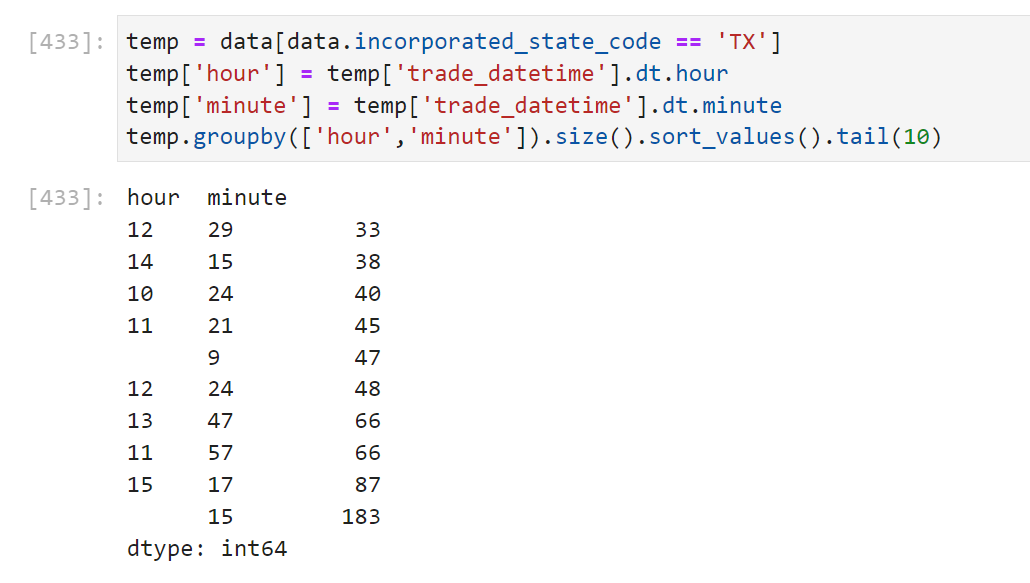
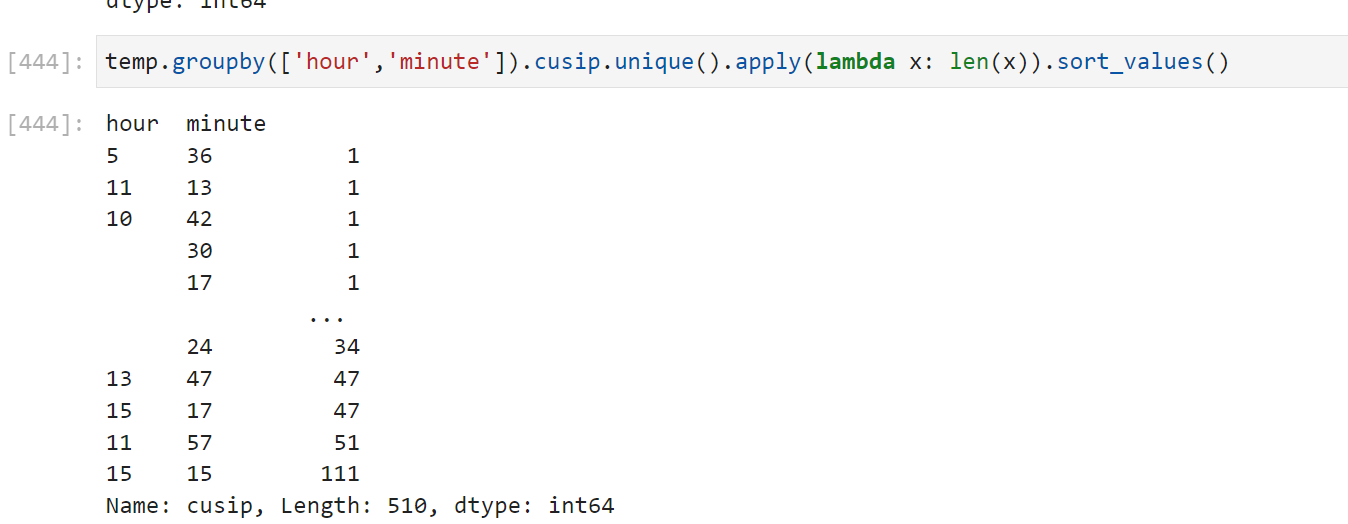

<AxesSubplot:xlabel='hour,minute'>

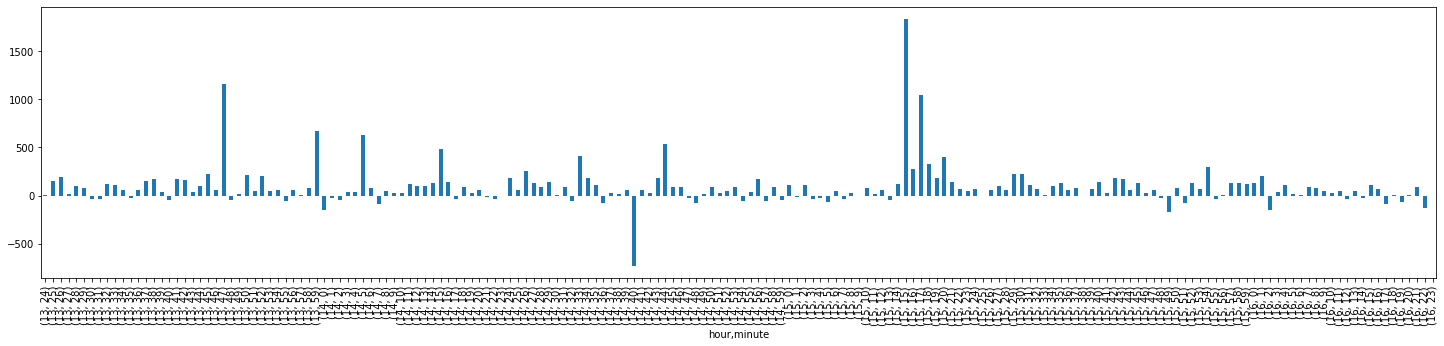

In [401]:
temp.reset_index(drop=True).groupby(['hour','minute']).error.sum().plot(kind='bar', figsize=(25,5))

In [410]:
temp.set_index('trade_datetime').loc['2023-07-05 15:15'].sort_values(by='error').tail(15)

,trade_date,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,error,next_call_date,...,bias,500,750,1000,2000,hour,minute,key,quantity,bias_unique
trade_datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-05 15:15:48,2023-07-05,2023-07-05 15:16:34,D,I,208399Q81,40000.0,289.0,308.622104,19.622104,None,...,2.283645,3.822943,2.978231,2.360195,1.402075,15,15,38582,4.602060,1.177689
2023-07-05 15:15:55,2023-07-05,2023-07-05 15:16:09,D,I,235219MU3,15000.0,305.7,325.370872,19.670872,None,...,3.805740,5.492249,4.073642,3.397762,1.797325,15,15,38758,4.176091,1.188599
2023-07-05 15:15:40,2023-07-05,2023-07-05 15:15:54,P,I,011415RJ7,40000.0,295.5,315.370607,19.870607,2027-08-15,...,1.168715,2.418958,1.816257,1.339556,1.059224,15,15,38419,4.602060,1.079369
2023-07-05 15:15:57,2023-07-05,2023-07-05 15:16:10,P,I,448492N95,35000.0,290.5,310.629503,20.129503,None,...,3.817433,5.516638,4.093633,3.446146,1.803950,15,15,38777,4.544068,1.282329
2023-07-05 15:15:46,2023-07-05,2023-07-05 15:15:57,P,I,516840YG4,15000.0,293.1,313.319805,20.219805,2027-08-01,...,1.369232,3.253363,2.632477,2.206959,1.319578,15,15,38528,4.176091,1.360064
2023-07-05 15:15:50,2023-07-05,2023-07-05 15:16:03,P,I,574204H97,15000.0,290.1,310.321455,20.221455,2027-09-01,...,2.418181,4.818752,3.491590,2.800173,1.616099,15,15,38665,4.176091,1.430538
2023-07-05 15:15:52,2023-07-05,2023-07-05 15:16:07,P,I,56756TAK0,40000.0,295.5,316.038943,20.538943,2028-07-01,...,2.848675,5.314861,3.953657,3.140613,1.832021,15,15,38701,4.602060,1.404312
2023-07-05 15:15:52,2023-07-05,2023-07-05 15:16:10,D,I,080496CM2,40000.0,320.0,342.252056,22.252056,2026-08-01,...,3.933642,5.261178,3.735382,3.136649,1.794171,15,15,38709,4.602060,1.083410
2023-07-05 15:15:52,2023-07-05,2023-07-05 15:16:07,P,I,385050YW3,20000.0,290.5,313.047614,22.547614,None,...,3.065741,5.268006,3.799427,3.139446,1.801087,15,15,38707,4.301030,1.217174


In [499]:
window = 2000
df = biases[0].sort_values(by='trade_datetime', ascending=True)
df['key'] = range(len(df))
# df['hour'] = df['trade_datetime'].dt.hour
# df['minute'] = df['trade_datetime'].dt.minute
# unique_df = df.groupby(['hour','minute','cusip']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
unique_df = df[~df.cusip.isin(texas_cusips)]
unique_df['bias_unique'] = bias_warm_start(simulate_weighted_average(unique_df, 'error', 'error', window_size=window, weighting_method='simple_average'), WARM)
df = pd.merge(df, 
         unique_df[['bias_unique','key']].reset_index(drop=True),
         on = 'key',
         how='outer'
        )
df.bias_unique = df.bias_unique.ffill()
debias_series(df['prediction'], df['yield'], df.bias_unique.fillna(0))
print('='*75)

Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 1.720, Original MAE: 9.625, Corrected bias: 0.215, Corrected MAE: 9.570


In [497]:
window = 2000
df = biases[0].sort_values(by='trade_datetime', ascending=True)
# df = df[~df.cusip.isin(texas_cusips)]
df['bias_unique'] = bias_warm_start(simulate_weighted_average(df, 'error', 'error', window_size=window, weighting_method='simple_average'), WARM)
# df.bias_unique = df.bias_unique.bfill()
debias_series(df['prediction'], df['yield'], df.bias_unique.fillna(0))
print('='*75)

Ignoring trades with errors larger than 35bps in bias correction calculations.
Original bias: 1.720, Original MAE: 9.625, Corrected bias: 0.194, Corrected MAE: 9.570


<AxesSubplot:xlabel='trade_datetime'>

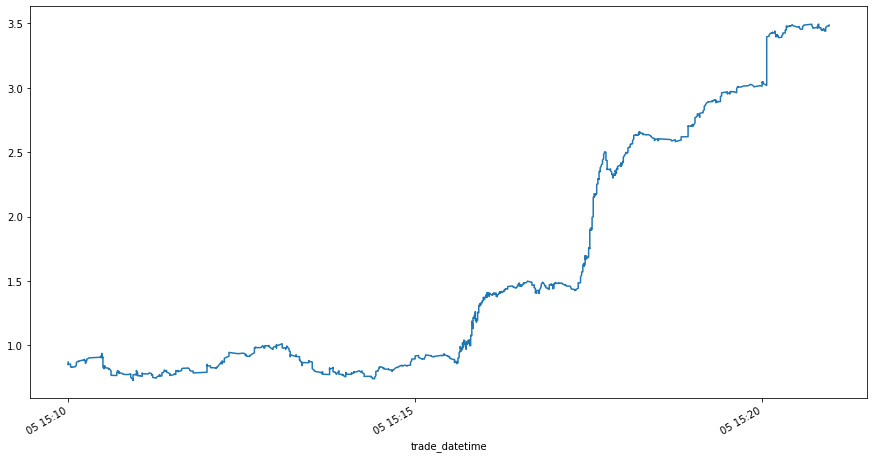

In [500]:
df.set_index('trade_datetime').loc['2023-07-05 15:10':'2023-07-05 15:20'].bias_unique.plot(figsize=(15,8))

### Multiple Files:

In [ ]:
files = ['biases/bias_calculations_2023-06-29.pkl',
 'biases/bias_calculations_2023-06-30.pkl',
 'biases/bias_calculations_2023-07-03.pkl']

In [ ]:
results = {}
for file in files: 
    biases = load_from_cloud_storage(f'gs://{file}',  fs)
    bias_windows = []
    for i in [500, 750, 1000, 2000]:
        %time x = simulate_weighted_average(biases[0], 'error', 'error', window_size = i, weighting_method='simple_average')
        bias_windows.append(bias_warm_start(x,WARM))
    bias_df = pd.DataFrame(bias_windows).T
    bias_df.columns =  [500, 750, 1000, 2000]
    biases[0][bias_df.columns] = bias_df
    results.update({biases[0].trade_date.iloc[-1].strftime(YYYYMMDD): biases[0]})

Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 15.1 s, sys: 91.6 ms, total: 15.2 s
Wall time: 15.3 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 14.3 s, sys: 107 ms, total: 14.4 s
Wall time: 14.4 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 8.44 s, sys: 88 ms, total: 8.53 s
Wall time: 8.52 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 15.4 s, sys: 55.7 ms, total: 15.4 s
Wall time: 15.5 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 12 s, sys: 83.9 ms, total: 12 s
Wall time: 12.1 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 11.5 s, sys: 59.9 ms, total: 11.6 s
Wall time: 11.7 s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 10.7 s, sys: 59.5 

In [ ]:
for col in bias_df.columns:
    debias_series(biases[0]['prediction'], biases[0]['yield'], bias_df[col])

ValueError: operands could not be broadcast together with shapes (16029,) (15908,) 

<AxesSubplot:>

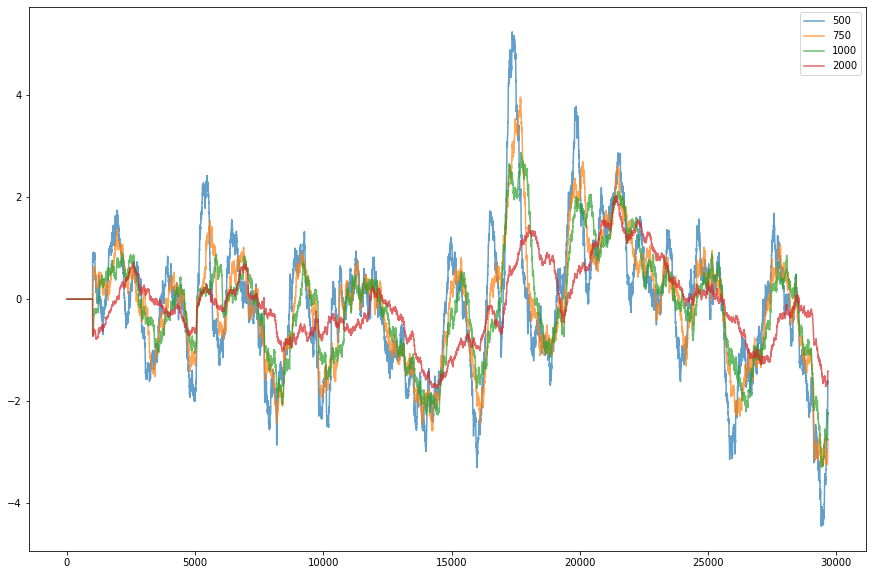

In [ ]:
results['2023-06-30'].plot(figsize=(15,10), alpha = 0.7)

<AxesSubplot:>

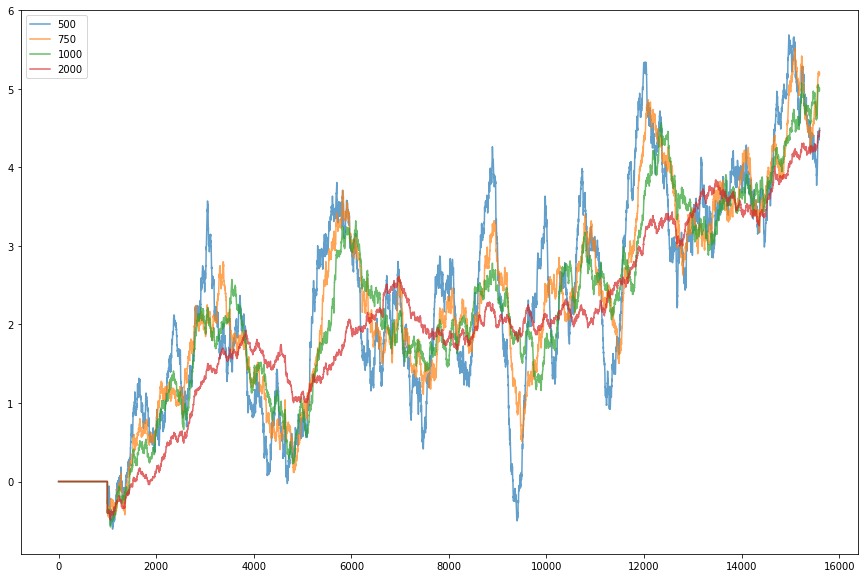

In [ ]:
bias_df.plot(figsize=(15,10), alpha = 0.7)

In [ ]:
groupby_df = biases[0].groupby('cusip').agg({'error':'mean', 'cusip':'size'}).rename({'cusip':'cusip_count'}, axis =1) \
.reset_index()\
.sort_values(by=['error','cusip_count'])

In [ ]:
biases[0][biases[0].cusip == '235219VW9']

,trade_date,trade_datetime,published_datetime,trade_type,transaction_type,cusip,par_traded,yield,prediction,error,next_call_date,maturity_date,refund_date,interest_payment_frequency,coupon_type,days_to_call,days_to_maturity,days_to_refund,bias
13577,2023-07-03,2023-07-03 11:22:07,2023-07-03 11:22:49,S,I,235219VW9,25000.0,493.9,294.023759,-199.876241,NaT,2031-02-15,NaT,16,4,0,2740,0,1.464224
13578,2023-07-03,2023-07-03 11:22:07,2023-07-03 11:22:49,D,I,235219VW9,25000.0,495.9,306.616106,-189.283894,NaT,2031-02-15,NaT,16,4,0,2740,0,1.460120
13579,2023-07-03,2023-07-03 11:21:46,2023-07-03 11:22:49,D,I,235219VW9,25000.0,495.9,306.616106,-189.283894,NaT,2031-02-15,NaT,16,4,0,2740,0,1.462353


In [ ]:
groupby_df[groupby_df.cusip_count >= 3]

,cusip,error,cusip_count
1413,235219VW9,-192.814676,3
6824,947729EK1,-178.983579,3
2213,41422PLL0,-141.923282,3
4851,67759YAJ6,-60.777865,4
552,127258CG4,-60.690828,4
...,...,...,...
7005,976904D82,58.549897,3
608,13048VYT9,69.148931,3
5384,740039AQ5,69.167713,4
931,160853SS7,83.064936,3


In [ ]:
biases = load_from_cloud_storage(f'gs://biases/bias_calculations_2023-07-03.pkl',  fs)

<AxesSubplot:>

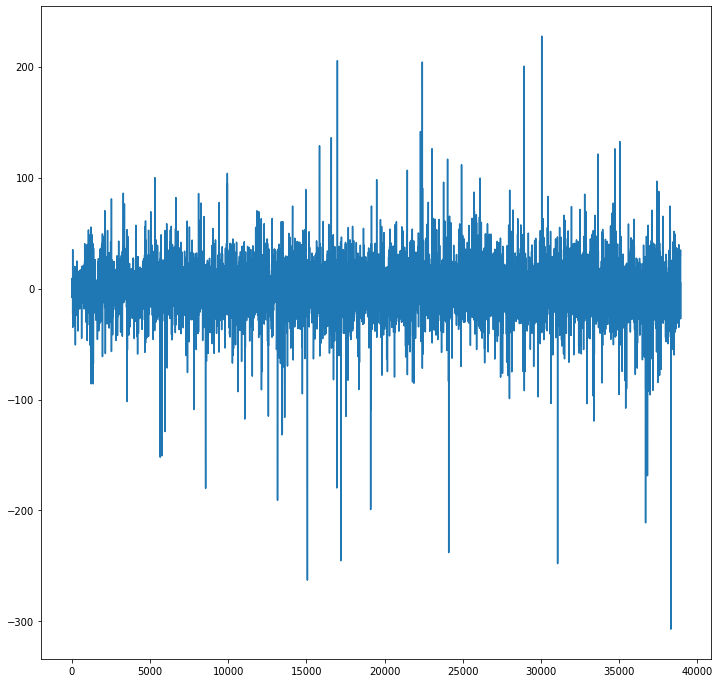

In [ ]:
biases[0].error.plot(figsize=(12,12))